# Can we regression model that can outperform the holding of an asset? These are some of the many questions that we will hope to answer.

## Table of Contents

- #### [Imports and data overview](#overview)
    - #### [Noting Data Issues](#initial-data-issues)
    - #### Working with Dynamic dataset


## Overview

In [142]:
import pandas as pd 
import numpy as np
#Regular expressions for fine-tuned searching
import re
import datetime
#Graphing
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
#Stats and modeling
from scipy.stats import t, skew, ttest_ind
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV, cross_validate, train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import svm
from sklearn.pipeline import Pipeline
from scipy.stats import ks_2samp
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz

Let's get our dataset and get an idea for what we're dealing with

In [47]:
df = pd.read_csv("financial_regression.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                3904 non-null   object 
 1   sp500 open          3719 non-null   float64
 2   sp500 high          3719 non-null   float64
 3   sp500 low           3719 non-null   float64
 4   sp500 close         3719 non-null   float64
 5   sp500 volume        3719 non-null   float64
 6   sp500 high-low      3719 non-null   float64
 7   nasdaq open         3719 non-null   float64
 8   nasdaq high         3719 non-null   float64
 9   nasdaq low          3719 non-null   float64
 10  nasdaq close        3719 non-null   float64
 11  nasdaq volume       3719 non-null   float64
 12  nasdaq high-low     3719 non-null   float64
 13  us_rates_%          176 non-null    float64
 14  CPI                 176 non-null    float64
 15  usd_chf             3694 non-null   float64
 16  eur_us

In [48]:
df.head(3)

,date,sp500 open,sp500 high,sp500 low,sp500 close,sp500 volume,sp500 high-low,nasdaq open,nasdaq high,nasdaq low,...,palladium high,palladium low,palladium close,palladium volume,palladium high-low,gold open,gold high,gold low,gold close,gold volume
0,2010-01-14,114.49,115.14,114.42,114.93,115646960.0,0.72,46.26,46.52,46.22,...,45.02,43.86,44.84,364528.0,1.16,111.51,112.37,110.79,112.03,18305238.0
1,2010-01-15,114.73,114.84,113.20,113.64,212252769.0,1.64,46.46,46.55,45.65,...,45.76,44.40,45.76,442210.0,1.36,111.35,112.01,110.38,110.86,18000724.0
2,2010-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Initial Data Issues 

- ##### Date is not of date type
- ##### NULLs
- ##### Non-standardized prices and volume

There are entire days with empty rows (probably weekends), and variables with many NULL entries.

## Data Cleaning

#### As you can see, the close price of an index on one day does not equal the open price of the same index on the following day. In order to account for the change in price after trading hours, we will look at the log returns of the close/open prices only. We will choose to use log returns of closing prices, volume, and the log difference of high/low within the same trading day. This addresses the issue of scaling our values to an extent. We will however need to determine if we will be overfitting due to high variable count.

In [49]:
#Drop the open prices, as we will only use closing prices for reasons mentioned above.
df = df.drop([col for col in df.columns if 'open' in col], axis=1)

The high - low columns do not reflect change relative to stock price. A better alternative is to use percent difference, or log return in our case

In [50]:
#Let's attain the list of unique asssets, via regex, that have closing price. This will exclude GDP, etc. that do not have low/high.
unique_assets = [re.findall(r"^(.*?)(?=\sclose)", c)[0] for c in df.columns if "close" in c]
print(unique_assets)

['sp500', 'nasdaq', 'silver', 'oil', 'platinum', 'palladium', 'gold']


In [51]:
#For each asset that has low/high: create a column that represents the log difference of high/low for same day:
for a in unique_assets:
    df.loc[:,f"{a} high/low"] = np.log(df.loc[:, f"{a} high"]/df.loc[:,f"{a} low"])

In [52]:
df[[col for col in df.columns if "high/low" in col]].head(3)

,sp500 high/low,nasdaq high/low,silver high/low,oil high/low,platinum high/low,palladium high/low,gold high/low
0,0.006273,0.006470,0.013459,0.014301,0.013248,0.026104,0.014160
1,0.014384,0.019523,0.009756,0.019147,0.010912,0.030171,0.014659
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we can drop the low/high columns using regex, as that information is already in the log diff. format

In [53]:
df = df.drop([col for col in df.columns if re.match(r"(.*\s(high|low|high-low)$)", col)], axis=1)

Our new dataset looks like so:

In [54]:
df.head(3)

,date,sp500 close,sp500 volume,nasdaq close,nasdaq volume,us_rates_%,CPI,usd_chf,eur_usd,GDP,...,palladium volume,gold close,gold volume,sp500 high/low,nasdaq high/low,silver high/low,oil high/low,platinum high/low,palladium high/low,gold high/low
0,2010-01-14,114.93,115646960.0,46.39,75209000.0,NaN,NaN,1.0206,1.4478,NaN,...,364528.0,112.03,18305238.0,0.006273,0.006470,0.013459,0.014301,0.013248,0.026104,0.014160
1,2010-01-15,113.64,212252769.0,45.85,126849300.0,NaN,NaN,1.0264,1.4376,NaN,...,442210.0,110.86,18000724.0,0.014384,0.019523,0.009756,0.019147,0.010912,0.030171,0.014659
2,2010-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now let's update our date column to be of type datetime 

In [55]:
df['date'] =df['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

#### Cleaning non-asset data

It's best to keep information regarding the difference in non_asset data such as CPI relative to when it was last updated. We will call this "shock". Applying a log return allows to take advantage of the additive properties of logarithms. But first, let's prepare said columns.

In [56]:
non_asset_columns = [col for col in df.columns if "close" not in col and "volume" not in col and "high/low" not in col]
#Columns that are not tradeable and are not Date:
print(non_asset_columns)

['date', 'us_rates_%', 'CPI', 'usd_chf', 'eur_usd', 'GDP']


As we can see, rates, CPI, and GDP are mostly nulls. What can we do about these to keep some of the info intact?

In [57]:
df[non_asset_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        3904 non-null   datetime64[ns]
 1   us_rates_%  176 non-null    float64       
 2   CPI         176 non-null    float64       
 3   usd_chf     3694 non-null   float64       
 4   eur_usd     3694 non-null   float64       
 5   GDP         57 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 183.1 KB


Why is the data missing? Well, while looking at GDP, we notice that the values are updated once per month. This makes sense as economic variables are typically estimated on a schedule.

In [58]:
df[non_asset_columns].query("GDP.notnull()").head(4)

,date,us_rates_%,CPI,usd_chf,eur_usd,GDP
55,2010-04-01,0.20,217.403,1.0559,1.3569,14980.193
121,2010-07-01,0.18,217.605,1.0675,1.2464,15141.607
188,2010-10-01,0.19,219.035,0.9761,1.3754,15309.474
254,2011-01-01,0.17,221.187,NaN,NaN,15351.448


We can also have columns representing CPI, usd_chf, eur_usd of latest available data by forward-filling. This will look reminiscent to a square wave (_ - _) and will allow us to calculate percent log returns (or shock)

Let's bring forward all known non-asset values to fill NULLs.

In [59]:
#non_asset_columns = [col for col in df.columns if "close" not in col and "volume" not in col and "high/low" not in col]
non_asset_date_columns =[col for col in non_asset_columns if "date" not in col]
df[non_asset_date_columns] = df[non_asset_date_columns].ffill()

Now, our non asset date columns such as CPI looks like so:

Text(0, 0.5, 'Value')

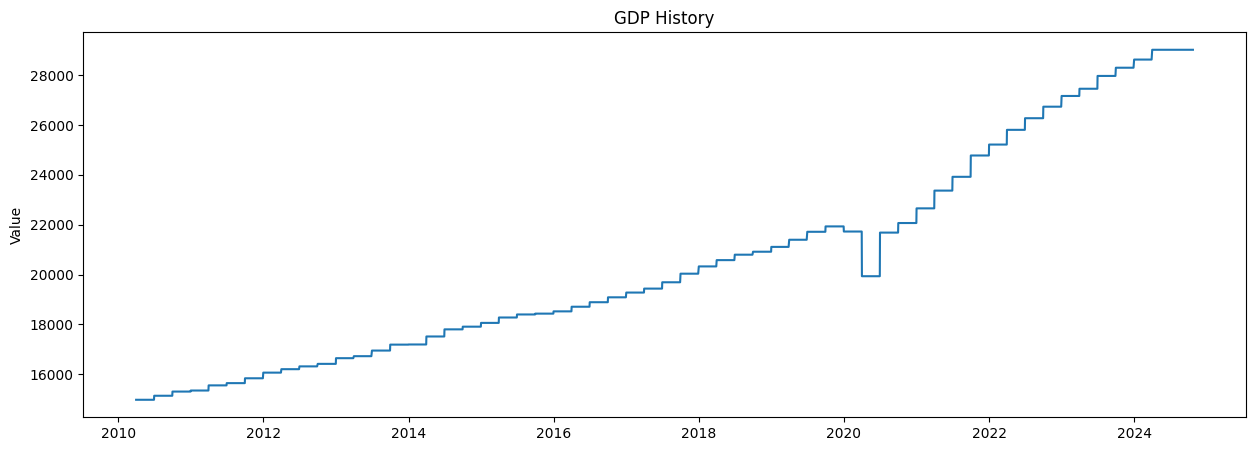

In [60]:
fix, ax = plt.subplots(figsize =(15,5))

ax.plot(df['date'], df['GDP'])
ax.set_title('GDP History')
ax.set_ylabel('Value')

Also note that there is one currency relationship that is USD over CHF, and another where it is the divisor (EUR/USD). Let's make invert it

In [61]:
df['usd_eur'] = 1/df['eur_usd']
df = df.drop("eur_usd", axis=1)

In [62]:
#Update our column list to reflect this change:
non_asset_columns = [col for col in df.columns if "close" not in col and "volume" not in col and "high/low" not in col]
non_asset_date_columns =[col for col in non_asset_columns if "date" not in col]

Let's create a log difference columns following the logic stated earlier: It's best to keep information regarding the difference in non_asset data such as CPI relative to when it was last updated. We will call this "shock". Applying a log return allows one to take advantage of the additive properties of logarithms.

Why use log returns, not % returns for analying returns? Log returns better resemble the underlying nature of compounding. For example, if we had a compounding 10% gain, and a -10% loss, one would be forgiven for assuming the investment neither grew nor shrank. The truth is, however, that the investment will have lost 1% -> [1.1*.9=.99]. If the stock market, hypothetically, had short term growth and shrinkage, but ultimately hovered around the same value (equilibream) at which it started, it would necessarily imply that the growth outweighed the shrinkage (x = positive loss less than 1 and greater than 0. $100 -> $100*(1-x)^n = $v -> $v * 1/((1-x)^n) -> $100). Where 1/(1-x) > (1+x). 

In [63]:
df[[col+"_shock" for col in non_asset_date_columns]] = np.log(df[non_asset_date_columns]/df[non_asset_date_columns].shift(1))

Note that inflation affects both GDP, CPI, S&P, etc. Let's look at the relationship between the NASDAQ and various non asset values such as CPI. First let's drop the rows that have empty values. All non-empty asset rows will be preserved.

In [64]:
df = df.dropna()

Get the asset specific columns representing the closing price, and total volume for the day:

In [65]:
asset_close_columns = [col for col in df.columns if "close" in col]
asset_volume_columns = [col for col in df.columns if "volume" in col]
pd.options.mode.chained_assignment = None
#Create log return columns represented by "change" in their column name:
df[[col + " change" for col in asset_close_columns]] = np.log(df[asset_close_columns]/df[asset_close_columns].shift(1))
df[[col + " change" for col in asset_volume_columns]] = np.log(df[asset_volume_columns]/df[asset_volume_columns].shift(1))

df = df.dropna()

In [66]:
df.columns

Index(['date', 'sp500 close', 'sp500 volume', 'nasdaq close', 'nasdaq volume',
       'us_rates_%', 'CPI', 'usd_chf', 'GDP', 'silver close', 'silver volume',
       'oil close', 'oil volume', 'platinum close', 'platinum volume',
       'palladium close', 'palladium volume', 'gold close', 'gold volume',
       'sp500 high/low', 'nasdaq high/low', 'silver high/low', 'oil high/low',
       'platinum high/low', 'palladium high/low', 'gold high/low', 'usd_eur',
       'us_rates_%_shock', 'CPI_shock', 'usd_chf_shock', 'GDP_shock',
       'usd_eur_shock', 'sp500 close change', 'nasdaq close change',
       'silver close change', 'oil close change', 'platinum close change',
       'palladium close change', 'gold close change', 'sp500 volume change',
       'nasdaq volume change', 'silver volume change', 'oil volume change',
       'platinum volume change', 'palladium volume change',
       'gold volume change'],
      dtype='object')

Do we have any left-over null values? No :)

In [68]:
df.isna().sum().sum()

0

### Create Target Column and Data Split

Let's create the training and test dataframes, and the log return of the closing prices of assets of the next day. They will be denoted by having 'target' in their names.

In [73]:
assets_change = [c + " change" for c in asset_close_columns]
for asset in assets_change:
    df[f"{asset} target"] = df[asset].shift(-1)
df = df.dropna()

In [74]:
X_col = [col for col in df.columns if "target" not in col]
y_col = [col for col in df.columns if "target" in col]

Ignore the validation set as we will later on use k-fold cross validation of the time series variety. We will leave 15% of our data for the test set (or roughly 2.2 years of trading days).

In [78]:
x_train, x_test, y_train, y_test = train_test_split( df[X_col],df[y_col], test_size=.15, shuffle=False)

### Visualization and Statistical Analysis

Now let's view the non-relative price of the NASDAQ relative to non-relative non-asset prices

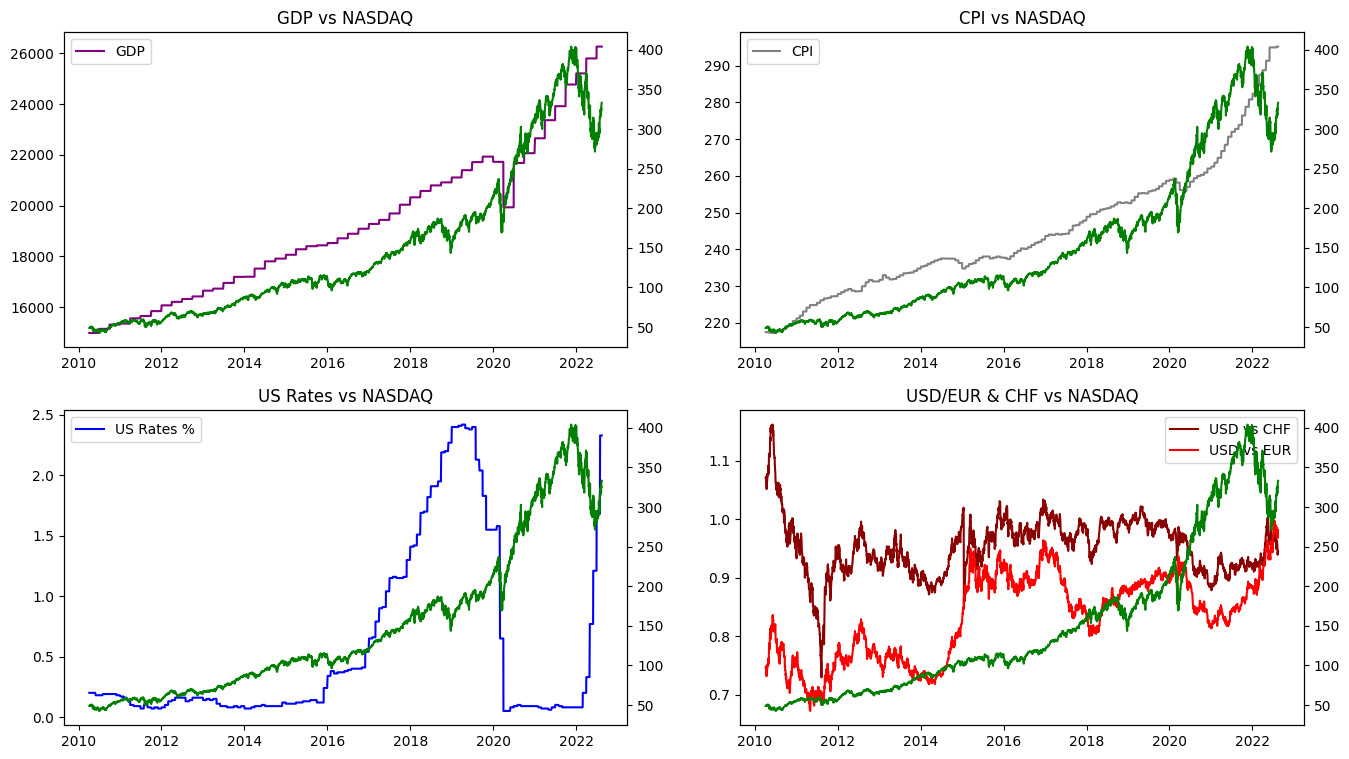

In [85]:
fig, axs = plt.subplots(2,2, figsize=(16, 9))
#GDP
axs[0,0].plot(x_train.date, x_train.GDP, label="GDP", color="purple")
axs[0,0].set_title("GDP vs NASDAQ")
axs[0,0].legend()
axs_spy = axs[0,0].twinx()
axs_spy.plot(x_train.date, x_train["nasdaq close"], label="nasdaq", color='g')

#US Rates
axs[1,0].plot(x_train.date, x_train["us_rates_%"], label="US Rates %", color="blue")
axs[1,0].set_title("US Rates vs NASDAQ")
axs[1,0].legend()
axs_spy = axs[1,0].twinx()
axs_spy.plot(x_train.date, x_train["nasdaq close"], label="NASDAQ", color='g')

#CPI
axs[0,1].plot(x_train.date, x_train["CPI"], label="CPI", color="grey")
axs[0,1].set_title("CPI vs NASDAQ")
axs[0,1].legend()
axs_spy = axs[0,1].twinx()
axs_spy.plot(x_train.date, x_train["nasdaq close"], label="Nasdaq", color='g')

#GDP
axs[1,1].plot(x_train.date, x_train.usd_chf, label="USD vs CHF", color="#8B0000")
axs[1,1].plot(x_train.date, x_train['usd_eur'], label="USD vs EUR", color="red")
axs[1,1].set_title("USD/EUR & CHF vs NASDAQ")
axs[1,1].legend()
axs_nasdaq = axs[1,1].twinx()
axs_nasdaq.plot(x_train.date, x_train["nasdaq close"], label="NASDAQ", color='g')

plt.show()

Although we will be developing predictive short term models using log returns, it's still interesting to see how currency status, CPI, US Rates, and GDP impact the S&P 500. It appears that GDP has a very strong reolationship to the stock market, and so does CPI. A lower dollar seems to imply a higher NASDAQ valuation, but that was in 2021-2022 which is most likely attributed to inflation.

Now that we viewed closing prices, we have no use for the non-relative volume and price, and high/low values, so let us remove them to avoid overfitting.

In [86]:
x_train = x_train.drop([c for c in x_train.columns if re.match(r".*\s(close|volume)$", c) or c in ["CPI", "usd_chf", "usd_eur", "us_rates_%", "GDP"]], axis=1)
x_test = x_test.drop([c for c in x_test.columns if re.match(r".*\s(close|volume)$", c) or c in ["CPI", "usd_chf", "usd_eur", "us_rates_%", "GDP"]], axis=1)

Our new data is now in relative log-return form, and looks like so:

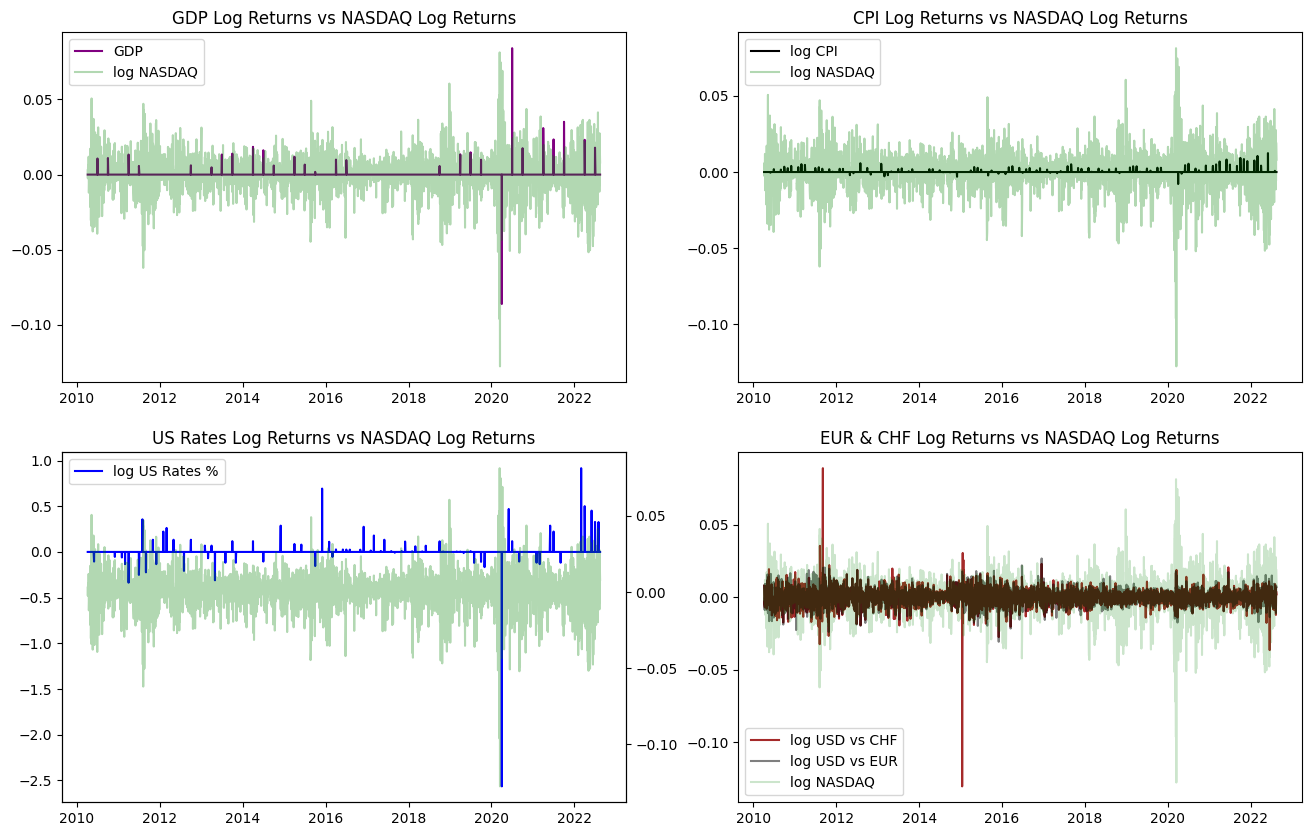

In [91]:
fig, axs = plt.subplots(2,2, figsize=(16,10))
#GDP
axs[0,0].plot(x_train.date, x_train.GDP_shock, label="GDP", color="purple")
axs[0,0].set_title("GDP Log Returns vs NASDAQ Log Returns")
#axs_spy = axs[0,0].twinx()
axs[0,0].plot(x_train.date, x_train["nasdaq close change"], label="log NASDAQ", color='g', alpha = 0.3)
axs[0,0].legend()


#US Rates
axs[1,0].plot(x_train.date, x_train["us_rates_%_shock"], label="log US Rates %", color="blue")
axs[1,0].set_title("US Rates Log Returns vs NASDAQ Log Returns")

axs_spy = axs[1,0].twinx()
axs_spy.plot(x_train.date, x_train["nasdaq close change"], label="log NASDAQ", color='g', alpha=0.3)
axs[1,0].legend()


#CPI
axs[0,1].plot(x_train.date, x_train["CPI_shock"], label="log CPI", color="black")
axs[0,1].set_title("CPI Log Returns vs NASDAQ Log Returns")
axs[0,1].plot(x_train.date, x_train["nasdaq close change"], label="log NASDAQ", color='g', alpha=0.3)
axs[0,1].legend()

# USD vs EUR & CHF Log Returns
axs[1, 1].plot(x_train.date, x_train['usd_chf_shock'], label="log USD vs CHF", color="brown")
axs[1, 1].plot(x_train.date, x_train['usd_eur_shock'], label="log USD vs EUR", color="black", alpha = 0.5)
axs[1, 1].plot(x_train.date, x_train["nasdaq close change"], label="log NASDAQ", color='g', alpha=0.2)
axs[1, 1].set_title("EUR & CHF Log Returns vs NASDAQ Log Returns")
axs[1, 1].legend()

plt.show()

What is the nature of the log returns as per distributions? Are returns normally distributed? Let's find out.

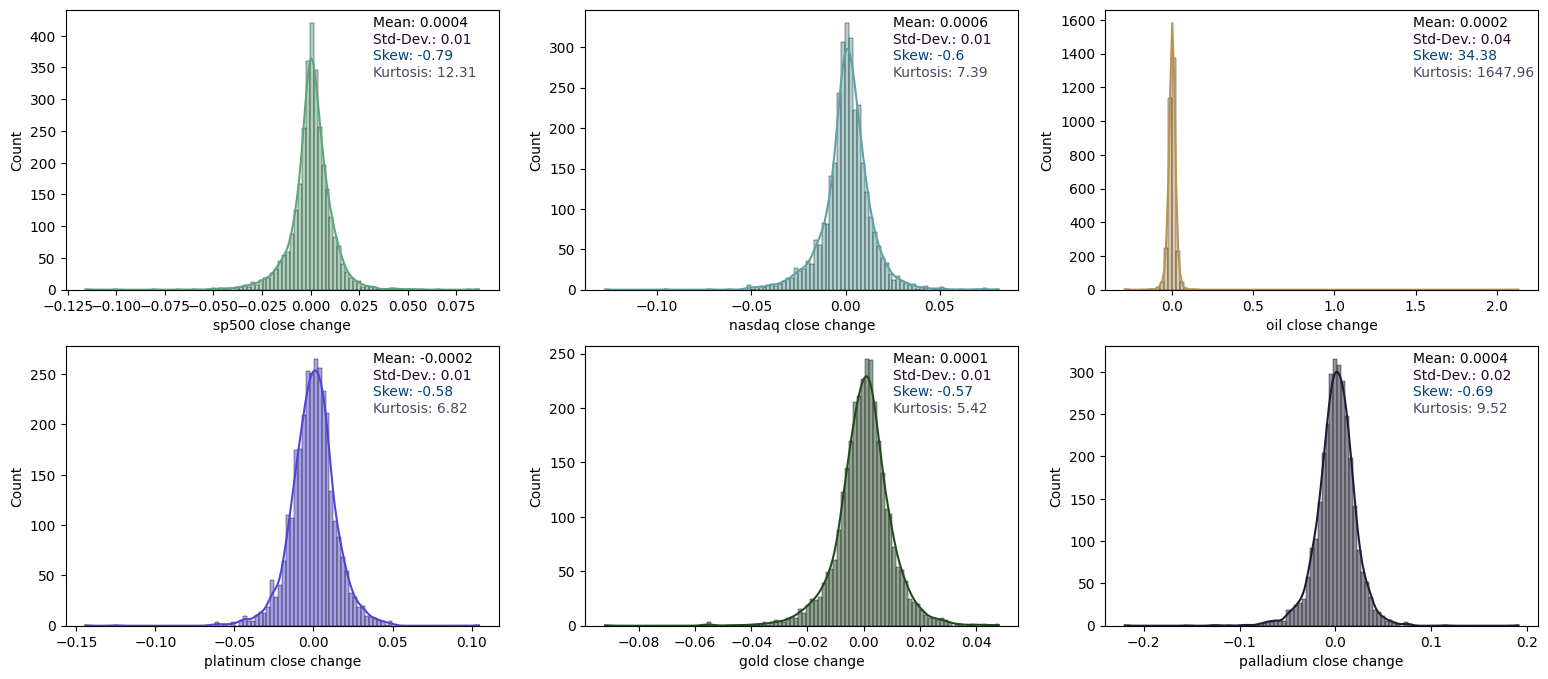

In [92]:
fig, axs = plt.subplots(2, 3, figsize=(19,8), sharex=False)
sns.histplot(x_train['sp500 close change'], kde=True, bins=100, ax = axs[0,0], color="#5EA57E")
sns.histplot(x_train['nasdaq close change'], kde=True, bins=100, ax = axs[0,1], color ="#5EA2A5")
sns.histplot(x_train['oil close change'], kde=True, bins=100, ax = axs[0,2], color="#B99352")
sns.histplot(x_train['platinum close change'], kde=True, bins=100, ax = axs[1,0], color ="#5144D4")
sns.histplot(x_train['gold close change'], kde=True, bins=100, ax = axs[1,1], color="#234923")
sns.histplot(x_train['palladium close change'], kde=True, bins=100, ax = axs[1,2], color ="#1F1D34")

for c in list(zip(enumerate(axs.reshape(-1)), ['sp500 close change','nasdaq close change', 'oil close change', 'platinum close change', 'gold close change','palladium close change'])):
    i=c[0][0]
    ax = c[0][1]
    column = c[-1]
    skew = np.round(x_train[column].skew(),2)
    mean = np.round(x_train[column].mean(),4)
    std_dev = np.round(x_train[column].std(),2)
    median = np.round(x_train[column].median(), 2)
    kurtosis = np.round(x_train[column].kurtosis(),2 )
    ax.text(x=0.71, y=0.94, s=f"Mean: {mean}", transform = ax.transAxes, color = 'black')
    ax.text(x=0.71, y=0.88, s=f"Std-Dev.: {std_dev}", transform = ax.transAxes, color = '#24042B')
    ax.text(x=0.71, y=0.82, s=f"Skew: {skew}", transform = ax.transAxes, color = '#054270')
    ax.text(x=0.71, y=0.76, s=f"Kurtosis: {kurtosis}", transform = ax.transAxes, color = '#4E4763')

What can we tell from the log return distributions? S&P 500, NASDAQ, Palladium, Gold, and Platinum seem to have very similar normal-esque distributions. Oil returns are either extremely stable or extremely volatile relative to other assets. This justifies its massive kurtosis. The S&P has a higher kurtosis when considering all non-oil assets, meaning that days with small returns/losses and relatively massive returns/losses are more frequent than in siblings. All log returns are left skewed except for oil. This implies more extreme losses in the left tails relative to gains in the right tails. What asset would be best to hold? These patterns will not necessarily continue into the future, but the NASDAQ has the highest mean return, so it would be a solid pick. Oil seems very volatile as well, with a right skew (although this is very likely thanks to a black swan outlier). We will consider oil returns in our case to develop a model.

Looking at the cause of this outlier shows us that the shock happens during the pandemic, which makes sense since oil prices were near $0, as suppliers didn't have enough storage to hold the oil. This would make it far easier to have a huge log return, as oil prices rebounded away from $0. We will not address this datapoint however, since all assets were experienceing great volatility at the time.

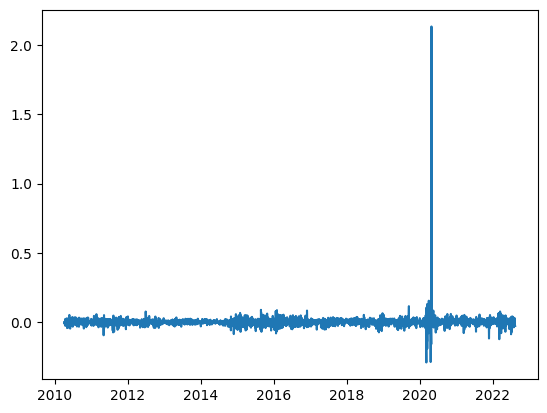

In [93]:
plt.plot(x_train.date, x_train['oil close change'])

Let's take a look at the Pearson (assuming linear) Correlation

<Axes: >

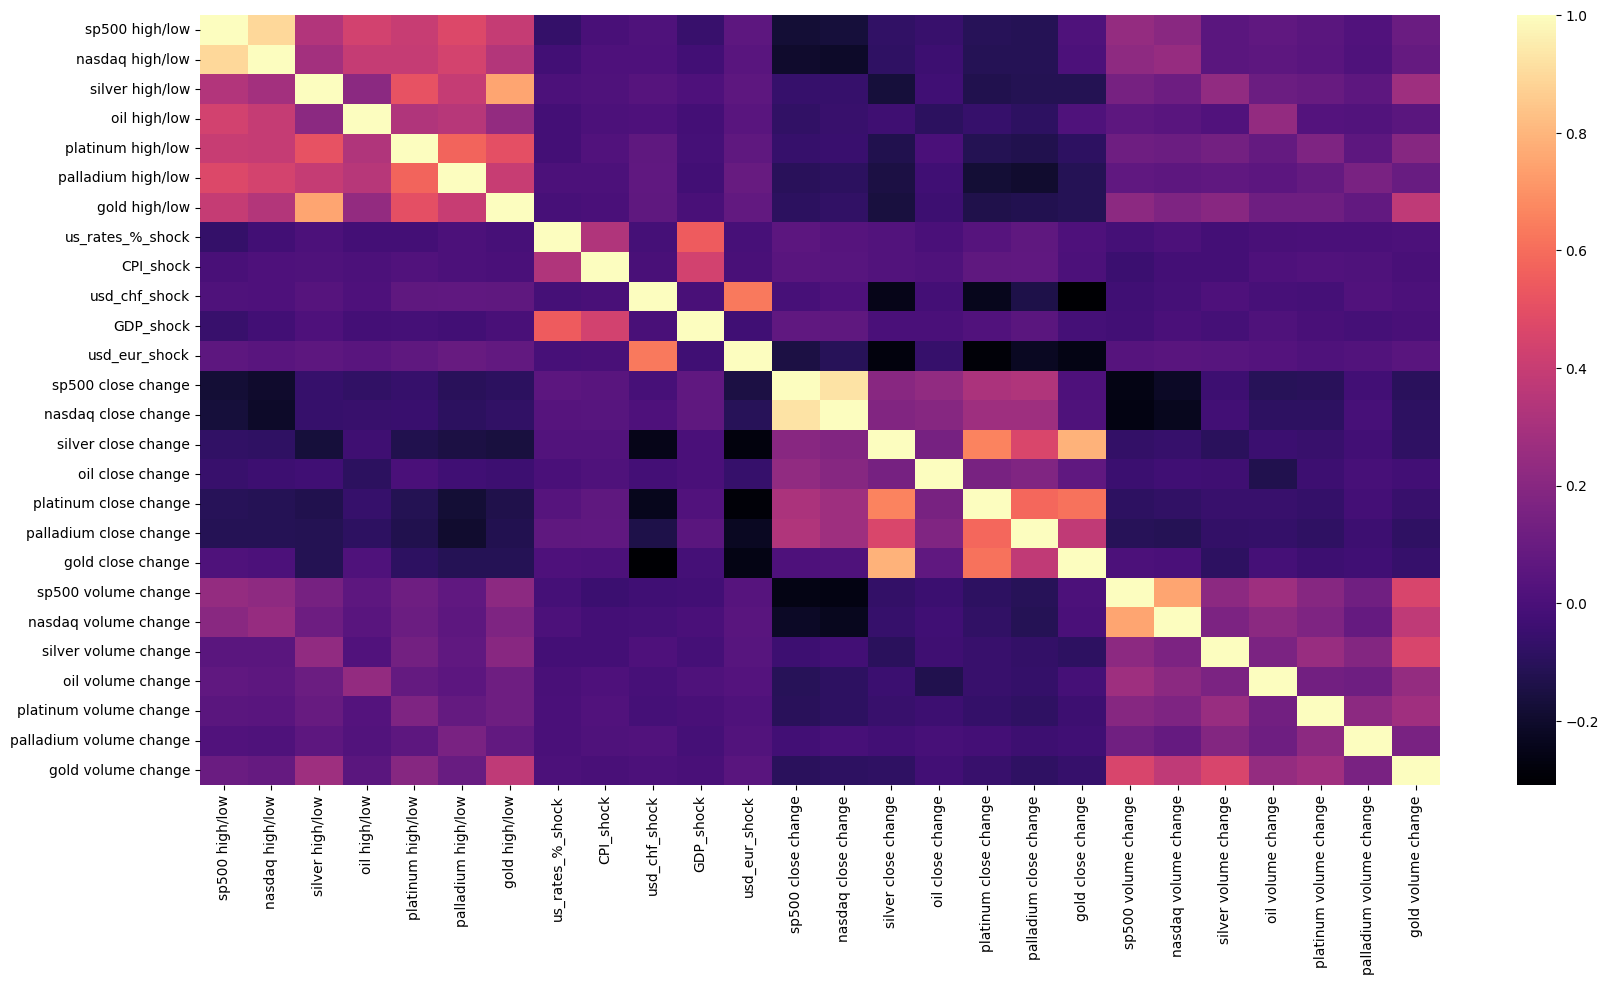

In [94]:
plt.figure(figsize=(20,10))
correlation = x_train[[col for col in x_train.columns if col != 'date']].corr()
sns.heatmap(correlation, cmap='magma')

### Colinearity
It would be best for us to remove 'sp500 close change', 'sp500 high/low' to address colinearity.

In [233]:
x_train.drop(columns=['sp500 close change', 'sp500 high/low'], axis=1, inplace=True)
x_test.drop(columns=['sp500 close change', 'sp500 high/low'], axis=1, inplace=True)

### What can we see from this correlation? The difference in high vs low of the previous 24 hours does not correlate to the returns of the same asset.
- #### The S&P 500 returns are fairly positively correlated to the NASDAQ returns. 
- #### Gold is modestly intertwined with silver
- #### US Rate changes are relatively positively correlated to CPI changes.
- #### USD vs EUR, as expected, is somewhat positively correlated to USD vs CHF

Log returns do scale our data to an extent. We choose to not puruse further scaling. This is because our data is time dependent and future average log returns may change, as well as the relationships between assets. However, for the purpose of seeing any relationships in lower dimensions, we will apply a standard scaler prior to reducing the number of dimensions via the PCA method.

In [234]:
scaler = StandardScaler()
x_train.iloc[:,1:] = scaler.fit_transform(x_train.iloc[:,1:])
pca = PCA(n_components=3, svd_solver="auto")
x_train_3D = pca.fit_transform(x_train.iloc[:,1:])
print("Total explained variance: ", np.round(100*np.sum(pca.explained_variance_ratio_),4), "%")

Total explained variance:  37.5436 %


Applying a PCA process on our data only accounts for ~38% of variance. This is far from perfect, but is useful for visualization. We will NOT be applying this in our cleaning process.

In [235]:
x = x_train_3D[:,0]
y = x_train_3D[:,1]
z = x_train_3D[:,2]
color = y_train['nasdaq close change target']

Log Return scale:


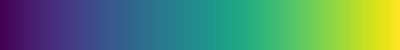

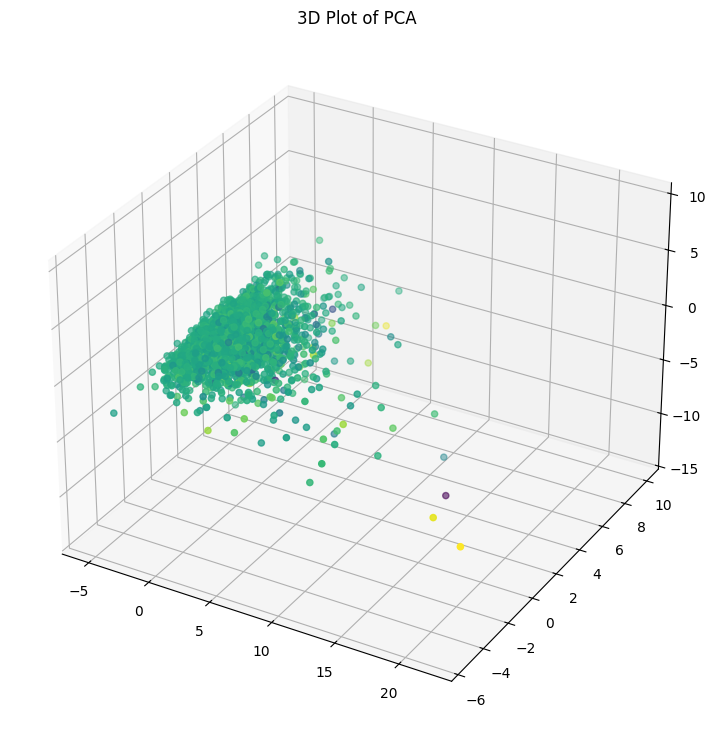

In [236]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z,c=color, cmap='viridis')
ax.set_title('3D Plot of PCA')
print("Log Return scale:")
Image('image.png')

![image.png](attachment:image.png)

This is strictly for visual purposes. Even though we won't be utilizing PCA later on, we will still be using SVM kernels in our high dimensional space. It's nice to see that there are some patterns that can possibly be utilized. For example, instances that fall far from the typical coordinates after PCA transformation, seem to be more likely to have either fairly large positive or negative returns. Instances that are similar in nature (grouped together in our 3D space), tend to have the same returns. Do note that the PCA projection onto 3 Dimensions is a very poor reflection on the total variance found in the intial dataset.

# Model Development

Let's use KFold cross validation to determine which models and parameters are most promising on our training set

In [237]:
def test_model(model, model_name):
    fig, axs = plt.subplots(2,3, figsize=(17,10), sharex=False)
    for c in list(zip(enumerate(axs.reshape(-1)), y_col)):
        i=c[0][0]
        ax = c[0][1]
        col = c[-1]
        linear_model = model
        linear_model.fit(x_train.iloc[:,1:], y_train[col])
        y_pred = linear_model.predict(x_train.iloc[:,1:])
        m, b = np.polyfit(y_pred, y_train[col], 1)
        r2 = r2_score(y_pred, y_train[col])
        mae = mean_absolute_error(y_pred, y_train[col])
        mse = mean_squared_error(y_pred, y_train[col])
        ax.plot(y_pred, y_pred * m + b, c="green")
        ax.set_xlabel("predicted")
        ax.set_ylabel("actual")
        ax.set_title(model_name + ": " + col)
        ax.scatter(y_pred, y_train[col])
        ax.text(x=0.78, y=0.14, s=f"Slope: {np.round(m,2)}", transform = ax.transAxes, color = 'black')
        ax.text(x=0.78, y=0.08, s=f"R2: {np.round(r2)}", transform = ax.transAxes, color = '#24042B')
        ax.text(x=0.78, y=0.02, s=f"MAE: {np.round(mae,3)}", transform = ax.transAxes, color = '#054270')
    #ax.text(x=0.71, y=0.76, s=f"MSE: {np.round(mse,3)}", transform = ax.transAxes, color = '#4E4763')

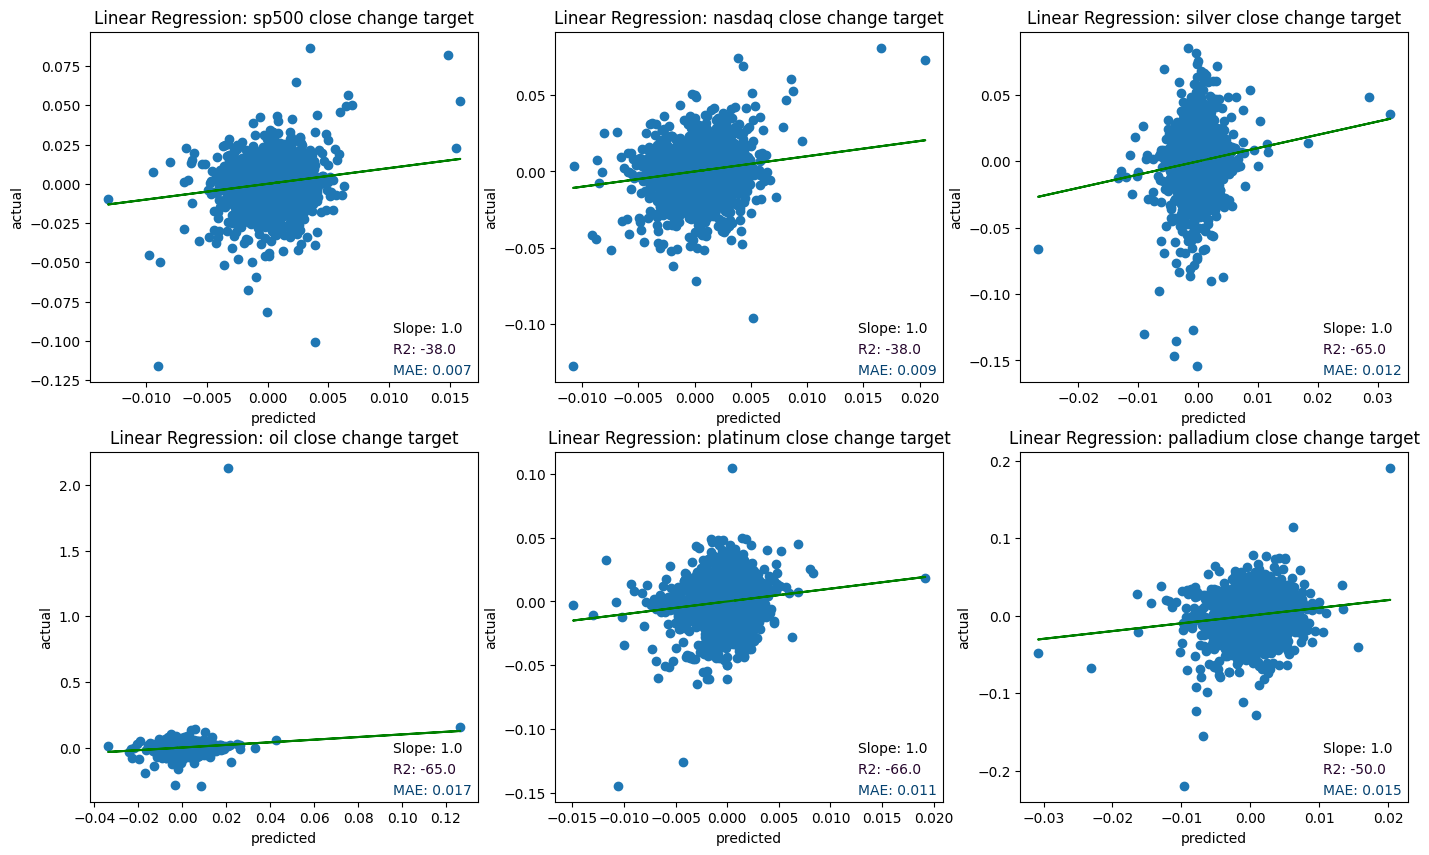

In [238]:
test_model(LinearRegression(), "Linear Regression")

According to the R2 values, all of these simple linear regression models fit very poorly. Let's try a decision tree regressor and build up.

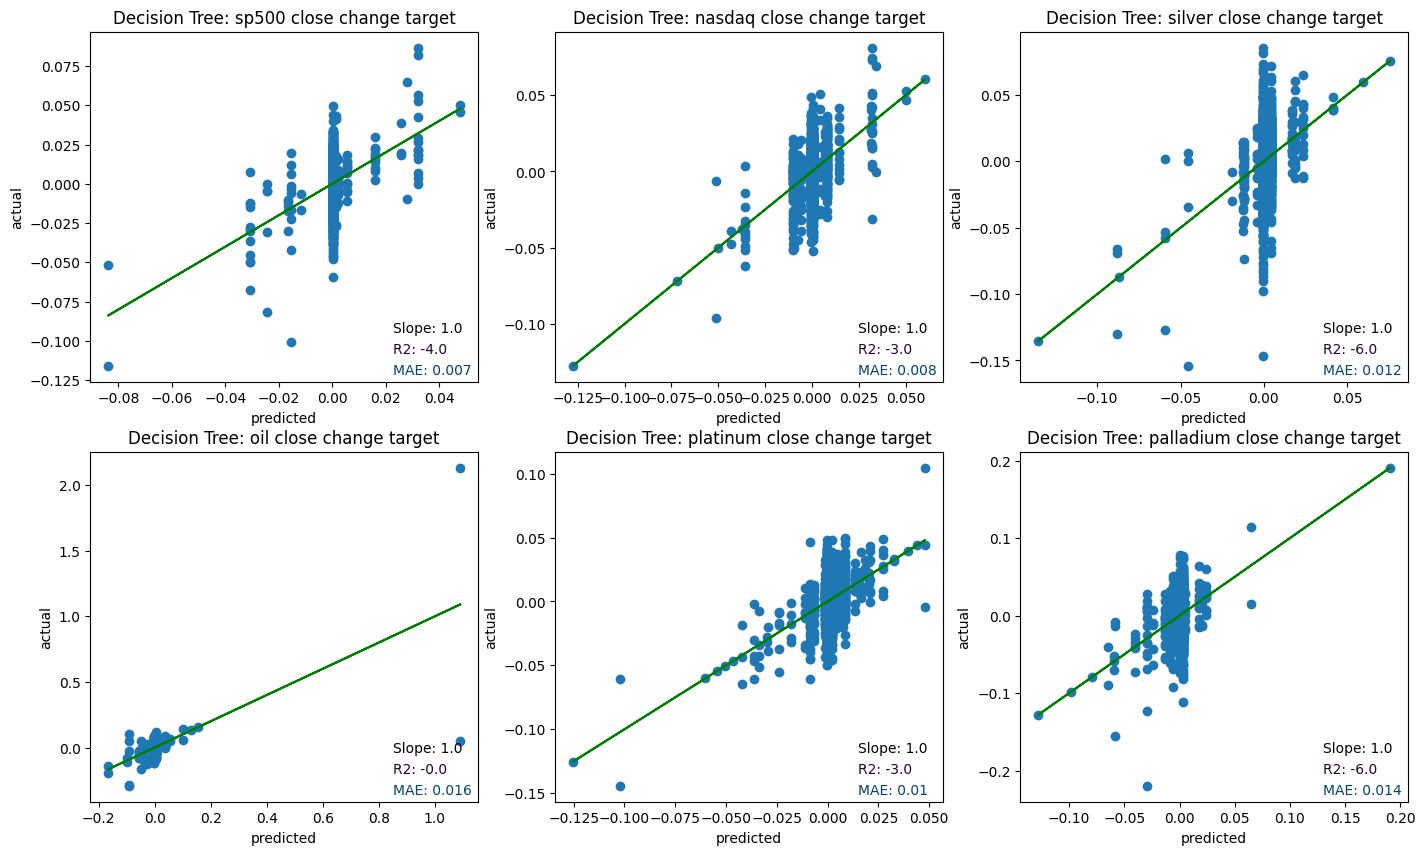

In [239]:
test_model(DecisionTreeRegressor(max_depth=10, min_samples_split=20), "Decision Tree")

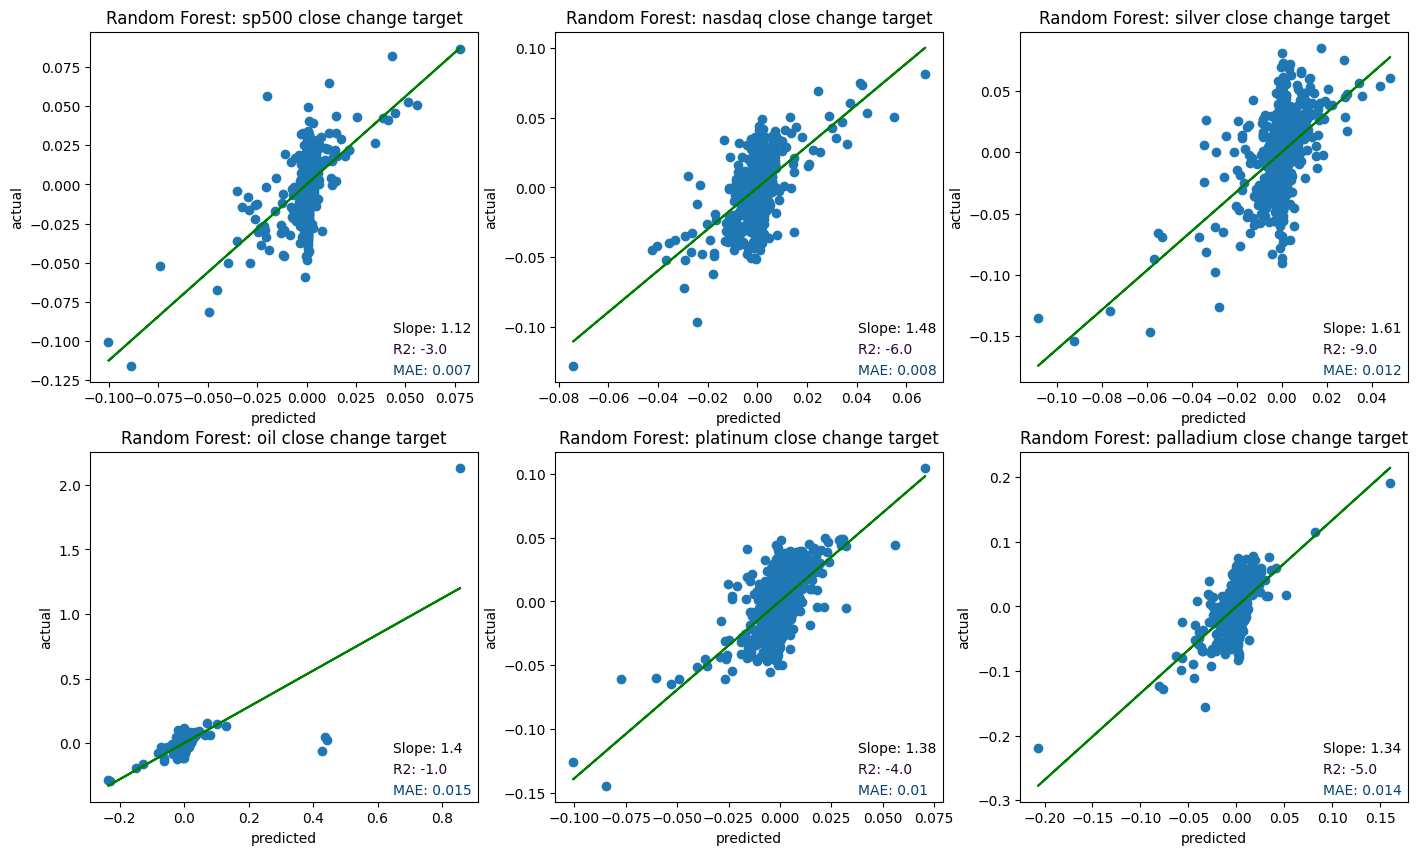

In [240]:
test_model(RandomForestRegressor(n_estimators=5, max_depth=10), "Random Forest")

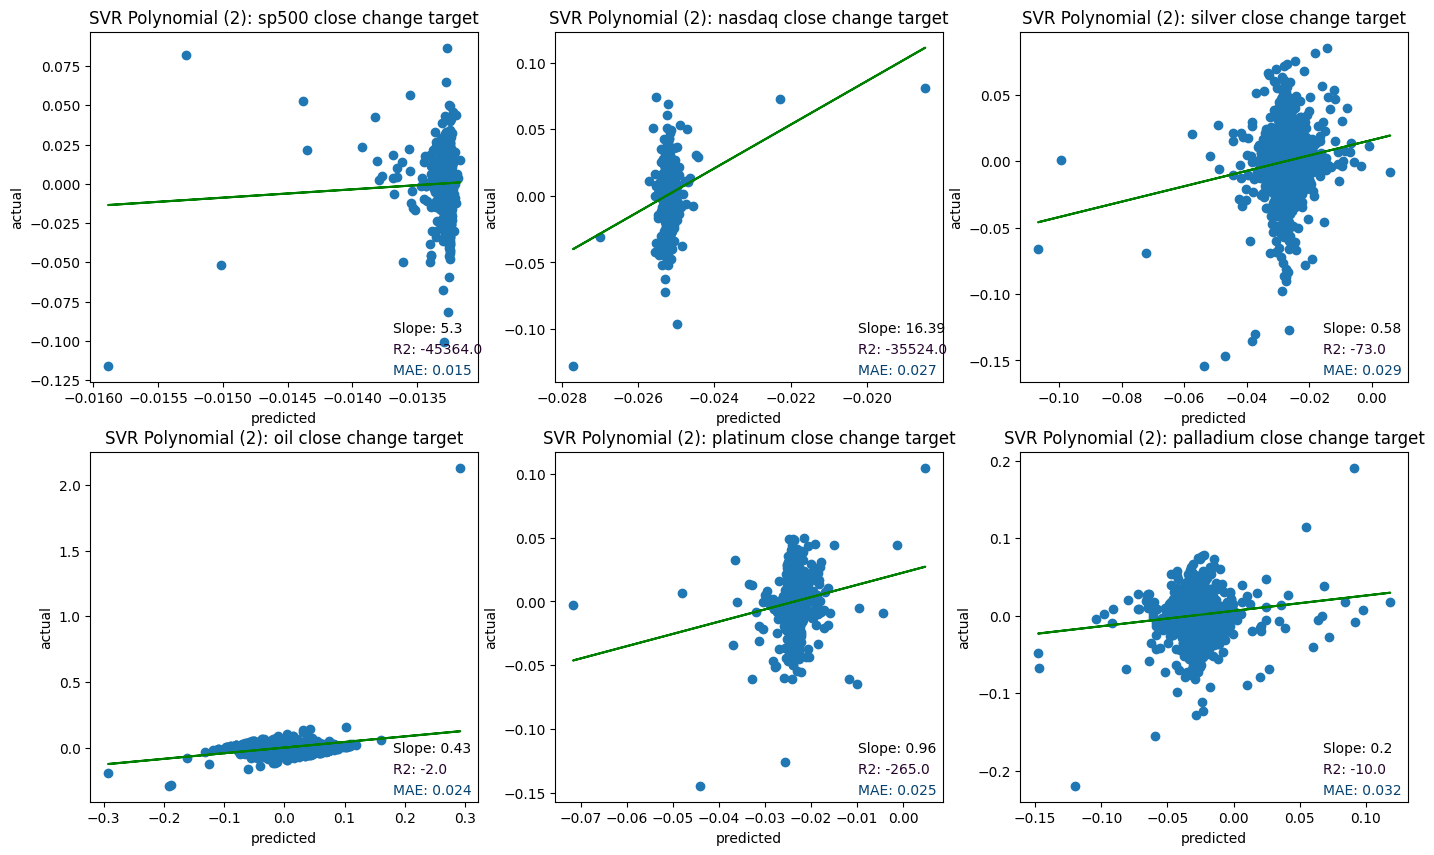

In [241]:
test_model(svm.SVR(kernel='poly', degree=2), "SVR Polynomial (2)")

It seems that simply using the mean will better explain the variability than our models. However, there is far too much noise involved, and we will simply seek to determine which days the assets will go up, so this measure is not as important as it may first seem. Clearly, assuming that the next day's return will be the same as the last (using mean), will not help us outperform the asset classes.

For our use, let's decide between predicting the next day's NASDAQ or oil returns, as these targets seem to be the most predictable among the default models. We will also build a sliding machine learning model that is trained on the previous x days to predict the next day's return

We want a model that is highly generalizable, so for this we will use Grid Search cross validation (exhaustive K-Fold search) on 5 sets. The polynomial model seems promising, so we will use polynomial features with a degree of 2 to test linear regression, SVMs, and a decision tree regressor. This allows us to better use potential multiplicative relationships of variables.

We will use Time Series Corss Validation to mimic the true nature of stock analysis (we can't see into the future)
This can be represented by the following steps:
#### Step 3: Train | Train | Train | Test
#### Step 2: Train | Train | Test
#### Step 1: Train | Test

In [248]:
#We will be predicting future returns, and as stated before, we assume that the dynamics of assets can change over time, so we will not shuffle, instead we will use TimeSeriesSplit
#We encapsulate code via a function to checkf for the best generalizable models for both oil returns and the NASDAQ

def grid_for_y_target(target_string):
    pipeline = Pipeline([('polynomial', PolynomialFeatures()), ('model', LinearRegression())])
    param_grid = [
        { 
            'polynomial__degree': [1,2],
            'model': [LinearRegression()]}
        ,{
            'polynomial__degree': [1,2],
            'model': [Ridge()],
            'model__alpha': [0.1, 1, 5]
        },
        #SVRs are less senstitive to outliers (e.g. OIL)
        {
            'model': [svm.SVR()],
            'model__kernel': [ 'rbf', 'poly'],
            'model__degree': [1,2,3],
            'model__epsilon': [.07,.1,.5, 1],
            'model__C': [.10, 1, 20]
        },
        {
            'polynomial__degree': [1,2],
            'model': [RandomForestRegressor()],
            'model__n_estimators': [20,45],
            'model__min_samples_leaf': [10,15]
        }
    ]
    time_series_split = TimeSeriesSplit(n_splits = 5)
    grid_search = GridSearchCV(pipeline, param_grid, cv=time_series_split, scoring = "neg_mean_squared_error", verbose= 1)
    grid_search.fit(x_train.iloc[:,1:], y_train[target_string])
    return grid_search

## NASDAQ Model

In [249]:
nasdaq_grid = grid_for_y_target('nasdaq close change target')

Fitting 5 folds for each of 88 candidates, totalling 440 fits


The best pipeline for predicting NASDAQ returns as determined by our K-Fold c.validation on the training set is applying polynomial features with a degree of 2 -> then training on a Random Forest Regressor with a minimum of 15 instances per leaf for the prevention of overfitting.

What is the best negative mean squared error score for the best estimator?

In [251]:
nasdaq_grid.best_score_

-0.00016854957945364537

In [252]:
nasdaq_pipe = nasdaq_grid.best_estimator_
nasdaq_pipe

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=1)),
                ('model',
                 RandomForestRegressor(min_samples_leaf=15, n_estimators=45))])

Let's visualize our Decision Tree model to check understand the logic.

In [253]:
nasdaq_pipe.fit(x_train.iloc[:,1:], y_train['nasdaq close change target'])
nasdaq_polynomial = nasdaq_pipe.named_steps['polynomial']
nasdaq_model = nasdaq_pipe.named_steps['model']
#Get a single decision tree regressor to view
nasdaq_model_single_tree = nasdaq_model.estimators_[1] 

In [254]:
#Export as visual:
viz_data = export_graphviz(nasdaq_model_single_tree, out_file = None, feature_names = nasdaq_polynomial.get_feature_names_out(x_train.iloc[:,1:].columns))
tree_graph = graphviz.Source(viz_data)
tree_graph.render("NASDAQ_decision_tree")

'NASDAQ_decision_tree.pdf'

One of the decision trees looks like so: We can see that our tree takes the second degree input of our data. In this case it assumes great importance on volume log change of gold and log difference of palladium for the same day to split the tree

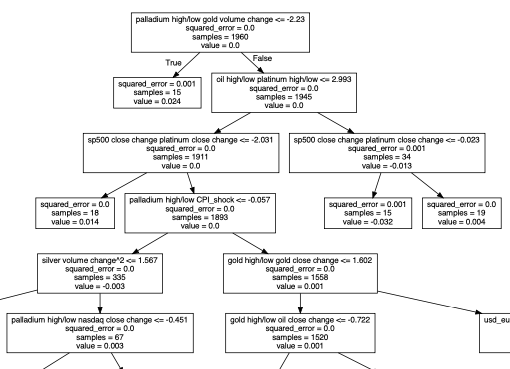

In [166]:
Image("sample_nasdaq_tree.png")

## Oil Model

In [250]:
oil_grid = grid_for_y_target('oil close change target')

Fitting 5 folds for each of 88 candidates, totalling 440 fits


In [255]:
oil_pipe = oil_grid.best_estimator_
oil_pipe

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=1)),
                ('model', Ridge(alpha=5))])

In [256]:
oil_pipe.fit(x_train.iloc[:,1:], y_train['oil close change target'])
oil_polynomial = oil_pipe.named_steps['polynomial']
oil_model = oil_pipe.named_steps['model']

What emphasis is placed on each input for our ridge model?

In [274]:
coefficient_columns = oil_polynomial.get_feature_names_out(x_train.iloc[:,1:].columns)

In [280]:
df_oil_coef = pd.DataFrame(oil_model.coef_, index = coefficient_columns, columns=['coefficient'] ).sort_values(by='coefficient', ascending=False)

In [282]:
df_oil_coef.head(3)

,coefficient
platinum close change,0.004499
platinum high/low,0.002165
CPI_shock,0.001255


<Axes: >

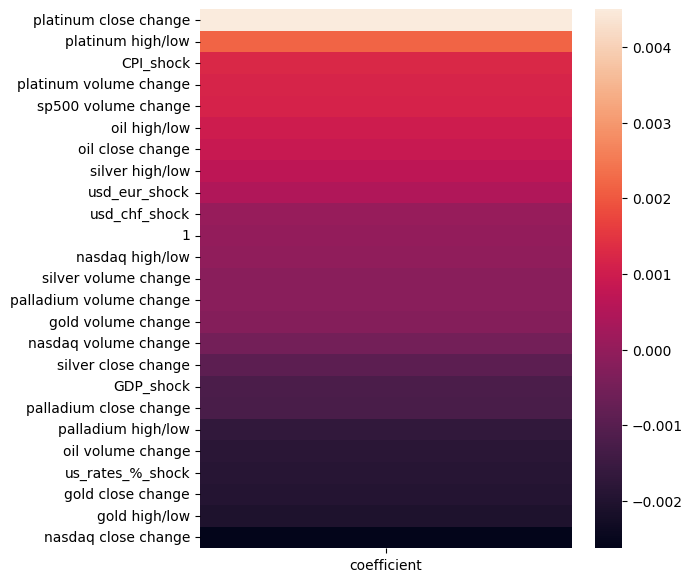

In [281]:
plt.figure(figsize=(6,7))
sns.heatmap(df_oil_coef, cmap="rocket")

This is interesting to say the least. What our Ridge model cofficients imply is that if the NASDAQ had a down day during the previous 24 hours, oil prices are more likely to rise during the next 24 hours. If the returns were positive, then oil prices are more likely to drop. The inverse is true for Platinum price change affect on oil.

What are some of the other models that ranked highly? They seem to be forms of Linear Regression using raw non-polynomial data.

In [283]:
pd.DataFrame(oil_grid.cv_results_).sort_values(by = "mean_test_score", ascending=False).head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_polynomial__degree,param_model__alpha,param_model__C,param_model__degree,param_model__epsilon,...,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.001807,0.000225,0.000608,0.000015,Ridge(),1.0,5.0,NaN,NaN,NaN,...,NaN,"{'model': Ridge(), 'model__alpha': 5, 'polynom...",-0.000188,-0.000642,-0.000328,-0.010019,-0.000583,-0.002352,0.003837,1
4,0.002377,0.000627,0.000690,0.000082,Ridge(),1.0,1.0,NaN,NaN,NaN,...,NaN,"{'model': Ridge(), 'model__alpha': 1, 'polynom...",-0.000188,-0.000642,-0.000328,-0.010019,-0.000584,-0.002352,0.003837,2
2,0.001836,0.000119,0.000644,0.000071,Ridge(),1.0,0.1,NaN,NaN,NaN,...,NaN,"{'model': Ridge(), 'model__alpha': 0.1, 'polyn...",-0.000189,-0.000642,-0.000328,-0.010019,-0.000584,-0.002352,0.003837,3
0,0.003213,0.000753,0.000736,0.000086,LinearRegression(),1.0,NaN,NaN,NaN,NaN,...,NaN,"{'model': LinearRegression(), 'polynomial__deg...",-0.000189,-0.000642,-0.000328,-0.010019,-0.000584,-0.002352,0.003837,4


## Predictions on Test Set

In [296]:
oil_test_set_prediction = pd.DataFrame(oil_pipe.predict(x_test.iloc[:,1:]), columns=['prediction'])
nas_test_set_prediction = pd.DataFrame(nasdaq_pipe.predict(x_test.iloc[:,1:]), columns = ['prediction'])

Let's merge the predictions with the actual results, to handle the data in two separate dataframes for ease.

In [298]:
oil_y_test = y_test[['oil close change target']].reset_index().drop(columns = ["index"]).merge(oil_test_set_prediction, left_index=True, right_index=True)
nas_y_test = y_test[['nasdaq close change target']].reset_index().drop(columns = ["index"]).merge(nas_test_set_prediction, left_index=True, right_index=True)

Our new data looks like so:

In [300]:
oil_y_test.head(3)

,oil close change target,prediction
0,0.011306,-0.000801
1,0.029539,0.001243
2,-0.002023,0.000231


### Model returns vs Asset returns

In [374]:
#Let's create a function to print the return based on our prediction (investing only when our model assumes that the next day the asset will rise) vs the buy and hold strategy of the asset (holding each day)
def print_returns_model_v_hold(df, threshold):
    log_sum_predicted_actual = np.sum(df.query(f"`prediction` >{threshold}")[[col for col in df.columns if "target" in col][0]], axis=0)
    log_sum_buy_hold = np.sum(df[[col for col in df.columns if "target" in col][0]], axis = 0)

    fraction_predicted_actual = 10**log_sum_predicted_actual
    fraction_buy_hold = 10**log_sum_buy_hold 

    n_days = df.shape[0]
    #Note: there are 252 trading days per year, so we will use the length of our df test to determine how many years the asset was held in total. 
    annualized_return_predicted_actual = fraction_predicted_actual**(252/n_days) - 1
    annualized_return_buy_hold = fraction_buy_hold**(252/n_days) - 1
    print(f"If you bought this asset and held for 24 hours only when the model predicted a greater than {threshold} log return for the following day, \nyour profit would be {np.round(100*(fraction_predicted_actual-1),1)}%, annualized to {np.round(100*(annualized_return_predicted_actual),1)}%. \
    \nIf you bought and held the entire time, your profit would be {np.round(100*(fraction_buy_hold-1),1)}%, annualized to {np.round(100*(annualized_return_buy_hold),1)}%")

In [375]:
print_returns_model_v_hold(oil_y_test, 0)

If you bought this asset and held for 24 hours only when the model predicted a greater than 0 log return for the following day, 
your profit would be 43.7%, annualized to 18.1%.     
If you bought and held the entire time, your profit would be 7.6%, annualized to 3.4%


In [382]:
print_returns_model_v_hold(nas_y_test, 0)

If you bought this asset and held for 24 hours only when the model predicted a greater than 0 log return for the following day, 
your profit would be 179.7%, annualized to 60.2%.     
If you bought and held the entire time, your profit would be 142.7%, annualized to 50.1%


We can see that using our model allows us to outperforma buy and hold strategy. But how likely is it to achieve the same results with a model is entirely random?

KeyError: 'sp500 close change'

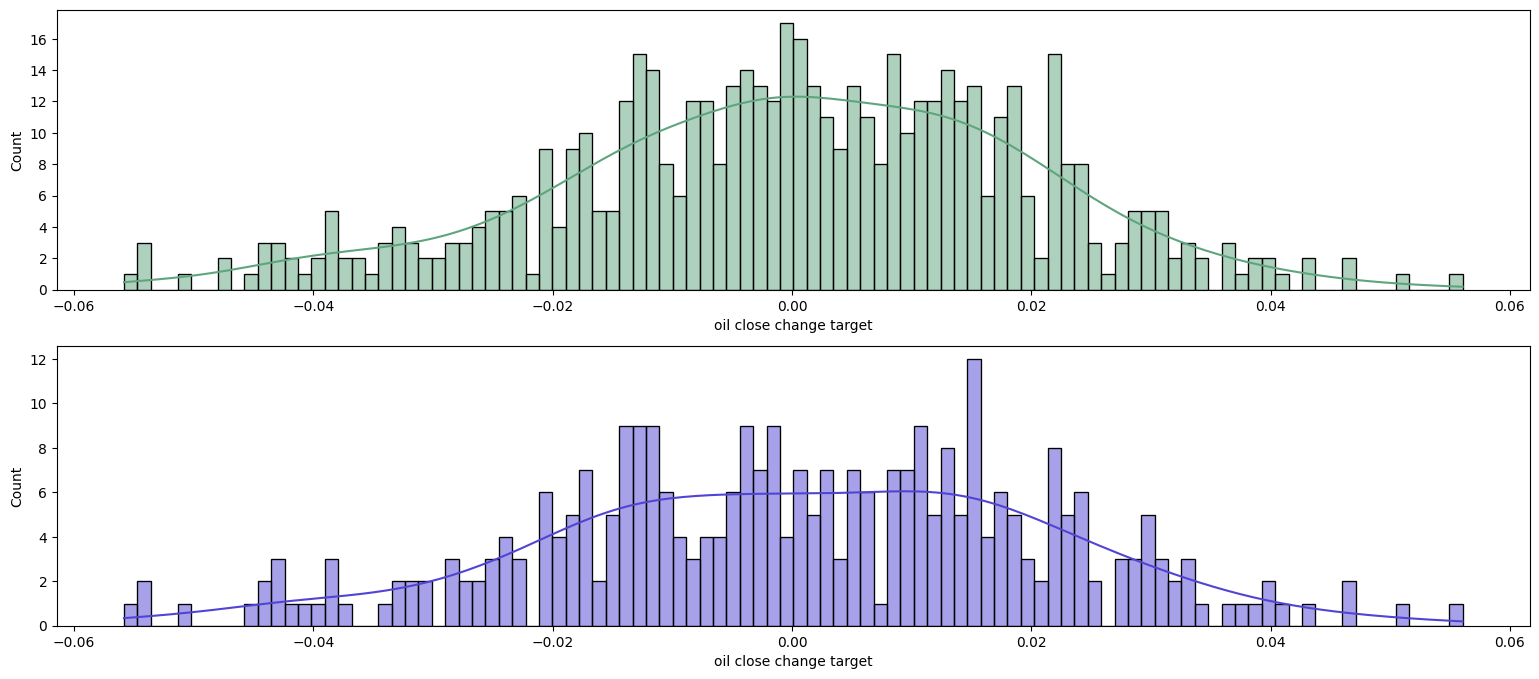

In [390]:
fig, axs = plt.subplots(2, 1, figsize=(19,8), sharex=False)
sns.histplot(oil_y_test['oil close change target'], kde=True, bins=100, ax = axs[0], color="#5EA57E")
sns.histplot(oil_y_test.query("`prediction` >0")['oil close change target'], kde=True, bins=100, ax = axs[1], color ="#5144D4")

for c in list(zip(enumerate(axs.reshape(-1)), ['sp500 close change','nasdaq close change', 'oil close change', 'platinum close change', 'gold close change','palladium close change'])):
    i=c[0][0]
    ax = c[0][1]
    column = c[-1]
    skew = np.round(x_train[column].skew(),2)
    mean = np.round(x_train[column].mean(),4)
    std_dev = np.round(x_train[column].std(),2)
    median = np.round(x_train[column].median(), 2)
    kurtosis = np.round(x_train[column].kurtosis(),2 )
    ax.text(x=0.71, y=0.94, s=f"Mean: {mean}", transform = ax.transAxes, color = 'black')
    ax.text(x=0.71, y=0.88, s=f"Std-Dev.: {std_dev}", transform = ax.transAxes, color = '#24042B')
    ax.text(x=0.71, y=0.82, s=f"Skew: {skew}", transform = ax.transAxes, color = '#054270')
    ax.text(x=0.71, y=0.76, s=f"Kurtosis: {kurtosis}", transform = ax.transAxes, color = '#4E4763')

<Axes: xlabel='oil close change target', ylabel='Count'>

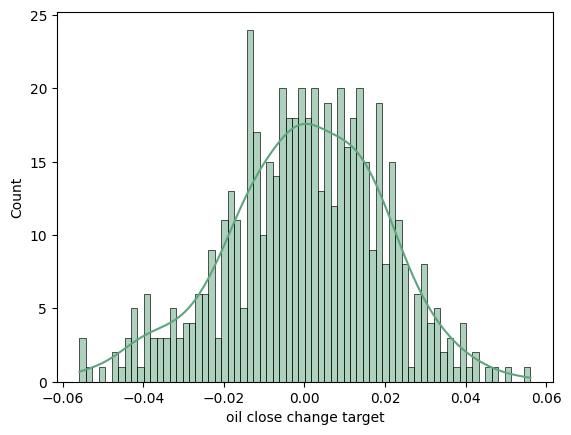

In [384]:
sns.histplot(oil_y_test['oil close change target'], kde=True, bins=70, color="#5EA57E")

<Axes: xlabel='oil close change target', ylabel='Count'>

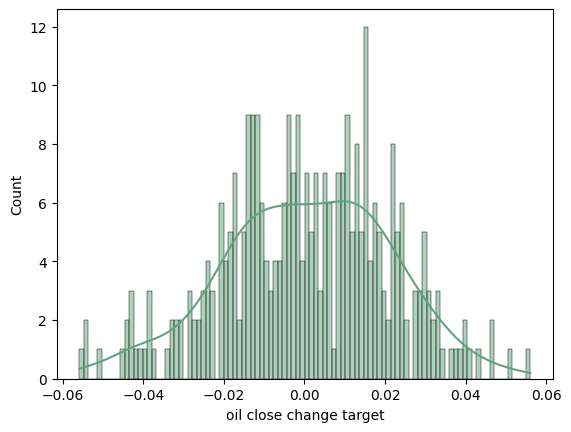

In [387]:
sns.histplot(oil_y_test.query("`prediction` >0")['oil close change target'], kde=True, bins=100, color="#5EA57E")

How likely is it for both sets of data to have come from the same source (how different are these distributions?)

In [275]:
ks, p = ks_2samp(y_all['oil close change target'], y_all.query("`test prediction` >0")['oil close change target'])
print("KS: ", ks)
print("p: ", p)

KS:  0.041175795813019785
p:  0.8664752401578008


In [296]:
y_all['oil close change target']

0      0.011306
1      0.029539
2     -0.002023
3      0.008337
4      0.028383
         ...   
545    0.003034
546   -0.017223
547    0.012253
548    0.023524
549   -0.005829
Name: oil close change target, Length: 550, dtype: float64

How random is this?

In [303]:
#Determine typical random return distribution:
returns = []
num = y_all.query("`test prediction` >0")['oil close change target'].shape[0]
for i in range(0,1100):
    total_log_return = np.sum(y_all['oil close change target'].sample(n=num))
    returns.append(total_log_return)

<Axes: ylabel='Count'>

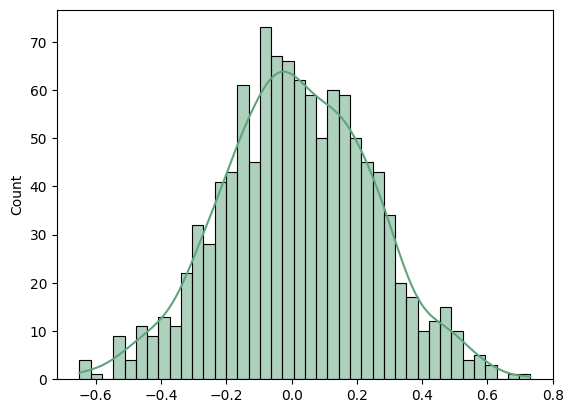

In [308]:
sns.histplot(returns, kde=True, bins=40, color="#5EA57E")

In [319]:
100 * pd.DataFrame(returns, columns = ['returns']).query("returns>0.116").shape[0] / pd.DataFrame(returns, columns = ['returns']).shape[0]

34.09090909090909

In [310]:
np.sum(y_all.query("`test prediction` >0")['oil close change target'])

0.11639612661241133

Let's try XGBoost

In [340]:
model = xgb.XGBRegressor(n_estimators=3000, max_depth=7, eta=0.4, subsample=0.7, colsample_bytree=0.7)
model.fit(x_train.iloc[:,1:], y_train['oil close change target'])
y_pred_xgb_ = pd.DataFrame(model.predict(x_test.iloc[:,1:]), columns = ["test prediction"]) 
y_all = y_test[['oil close change target']].reset_index().drop(columns = ["index"]).merge(y_pred_xgb_, left_index=True, right_index=True)
np.sum(y_all.query("`test prediction` >0")['oil close change target'])

0.2304402770043682

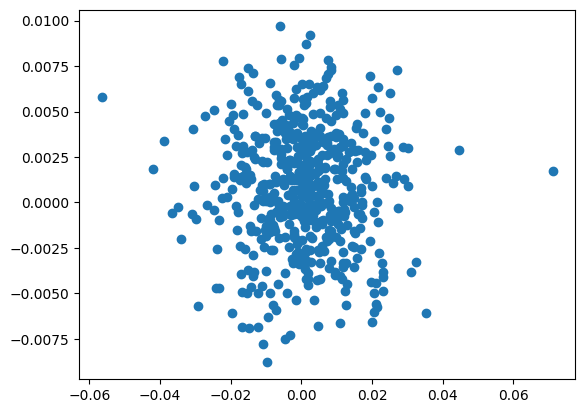

In [325]:
plt.scatter(y_test['nasdaq close change target'], y_pred_xgb_ )

In [295]:
print(y_all.query("`test prediction` >0")['oil close change target'].shape[0])

317


In [300]:
np.array([1]) + 2

array([3])

Let's test the t distribution for positive values only:

In [292]:
deg_freedom = y_all.query("`test prediction` >0")['oil close change target'].shape[0]-1
y =t.pdf(y_all.query['oil close change target'], deg_freedom)


316

In [286]:
10**np.sum(pd.concat([y_all.query("`test prediction` >0")['oil close change target'].reset_index(drop=True), -1*y_all.query("`test prediction` < 0")['oil close change target'].reset_index(drop=True)]))

1.5881125018782911

<Axes: xlabel='oil close change target', ylabel='Count'>

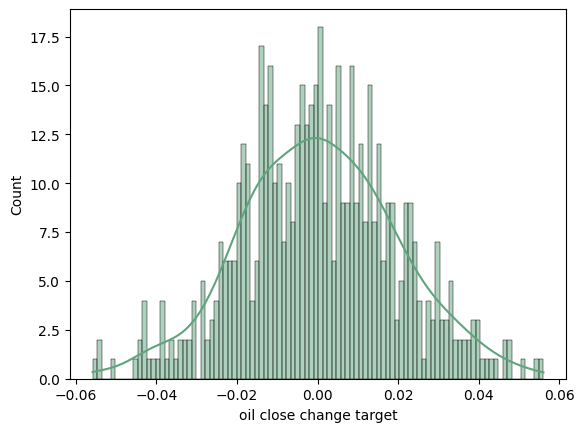

In [288]:
sns.histplot(pd.concat([y_all.query("`test prediction` >0")['oil close change target'].reset_index(drop=True), -1*y_all.query("`test prediction` < 0")['oil close change target'].reset_index(drop=True)]), kde=True, bins=100, color="#5EA57E")

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(19,8), sharex=False)
sns.histplot(x_train['sp500 close change'], kde=True, bins=100, ax = axs[0,0], color="#5EA57E")
sns.histplot(x_train['nasdaq close change'], kde=True, bins=100, ax = axs[0,1], color ="#5EA2A5")
sns.histplot(x_train['oil close change'], kde=True, bins=100, ax = axs[0,2], color="#B99352")
sns.histplot(x_train['platinum close change'], kde=True, bins=100, ax = axs[1,0], color ="#5144D4")
sns.histplot(x_train['gold close change'], kde=True, bins=100, ax = axs[1,1], color="#234923")
sns.histplot(x_train['palladium close change'], kde=True, bins=100, ax = axs[1,2], color ="#1F1D34")

for c in list(zip(enumerate(axs.reshape(-1)), ['sp500 close change','nasdaq close change', 'oil close change', 'platinum close change', 'gold close change','palladium close change'])):
    i=c[0][0]
    ax = c[0][1]
    column = c[-1]
    skew = np.round(x_train[column].skew(),2)
    mean = np.round(x_train[column].mean(),4)
    std_dev = np.round(x_train[column].std(),2)
    median = np.round(x_train[column].median(), 2)
    kurtosis = np.round(x_train[column].kurtosis(),2 )
    ax.text(x=0.71, y=0.94, s=f"Mean: {mean}", transform = ax.transAxes, color = 'black')
    ax.text(x=0.71, y=0.88, s=f"Std-Dev.: {std_dev}", transform = ax.transAxes, color = '#24042B')
    ax.text(x=0.71, y=0.82, s=f"Skew: {skew}", transform = ax.transAxes, color = '#054270')
    ax.text(x=0.71, y=0.76, s=f"Kurtosis: {kurtosis}", transform = ax.transAxes, color = '#4E4763')

In [257]:
prediction = pd.DataFrame(y_test_pred, columns = ["test prediction"])  

In [256]:
predicted_values

,test prediction
0,-0.000764
1,0.001234
2,0.000208
3,0.001443
4,-0.001235
...,...
545,0.000788
546,0.000524
547,-0.000698
548,0.000319


In [262]:
y_all = y_test[['oil close change target']].reset_index().drop(columns = ["index"]).merge(prediction, left_index=True, right_index=True)

In [263]:
y_all

,oil close change target,test prediction
0,0.011306,-0.000764
1,0.029539,0.001234
2,-0.002023,0.000208
3,0.008337,0.001443
4,0.028383,-0.001235
...,...,...
545,0.003034,0.000788
546,-0.017223,0.000524
547,0.012253,-0.000698
548,0.023524,0.000319


In [ ]:
oil_pipe = oil_grid.best_estimator_
plt.scatter(y_test['oil close change target'], oil_pipe.predict(x_test.iloc[:,1:]) )

In [163]:
oil_grid.best_estimator_, oil_grid.best_score_

(Pipeline(steps=[('polynomial', PolynomialFeatures()),
                 ('model',
                  RandomForestRegressor(max_depth=4, min_samples_leaf=25,
                                        n_estimators=25))]),
 -0.0023438338439591123)

In [200]:
#nasdaq_results = pd.DataFrame(nasdaq_grid.cv_results_)
#nasdaq_results.sort_values(by = "rank_test_score", ascending=False).params

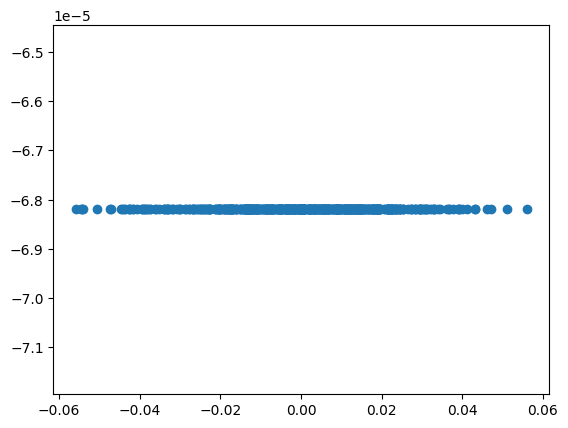

In [199]:
plt.scatter(y_test['oil close change target'], oil_pipe.predict(x_test.iloc[:,1:]) )

Text(0.78, 0.02, 'MAE: 0.009')

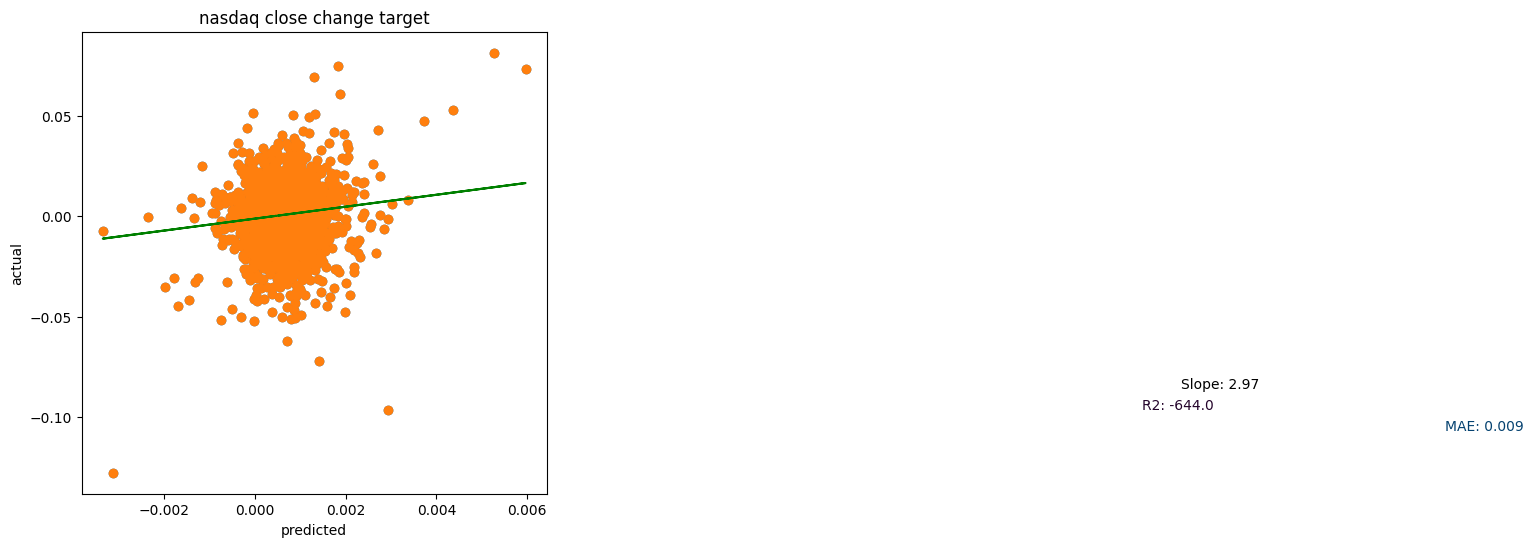

In [195]:
fig, axs = plt.subplots(1,1, figsize=(6,6), sharex=False)

col = 'nasdaq close change target'
nasdaq_pipe.fit(x_train.iloc[:,1:], y_train['nasdaq close change target'])
y_pred = nasdaq_pipe.predict(x_train.iloc[:,1:])
plt.scatter(y_pred, y_train[col])
m, b = np.polyfit(y_pred, y_train[col], 1)
r2 = r2_score(y_pred, y_train[col])
mae = mean_absolute_error(y_pred, y_train[col])
mse = mean_squared_error(y_pred, y_train[col])
plt.plot(y_pred, y_pred * m + b, c="green")
axs.set_xlabel("predicted")
axs.set_ylabel("actual")
axs.scatter(y_pred, y_train[col])
axs.text(x=0.10, y=0.14, s=f"Slope: {np.round(m,2)}", transform = ax.transAxes, color = 'black')
axs.set_title(col)
axs.text(x=0, y=0.08, s=f"R2: {np.round(r2)}", transform = ax.transAxes, color = '#24042B')
axs.text(x=0.78, y=0.02, s=f"MAE: {np.round(mae,3)}", transform = ax.transAxes, color = '#054270')

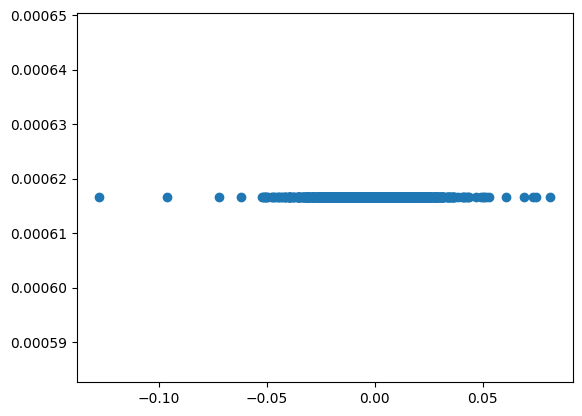

In [183]:
nasdaq_pipe.fit(x_train.iloc[:,1:], y_train['nasdaq close change target'])
y_train_pred = nasdaq_pipe.predict(x_train.iloc[:,1:])
plt.scatter( y_train['nasdaq close change target'], y_nasdaq_pred)

In [ ]:
oil_pipe.fit(x_train.iloc[:,1:], y_train['oil close change target'])
oil_train_pred = oil_pipe.predict(x_train.iloc[:,1:])
plt.scatter( y_train['oil close change target'], y_oil_pred)

In [174]:
#nasdaq_results.sort_values(by = "mean_test_score", ascending=False)

In [217]:
pd.DataFrame(nasdaq_grid.cv_results_).tail(9)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_polynomial__degree,param_model__alpha,param_model__C,param_model__degree,param_model__epsilon,...,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
75,0.005154,0.002109,0.001252,0.000150,SVR(),NaN,NaN,20.0,3.0,0.1,...,NaN,"{'model': SVR(), 'model__C': 20, 'model__degre...",-0.000120,-0.000149,-0.000125,-0.000351,-0.000915,-0.000332,0.000304,72
76,0.004648,0.001665,0.001429,0.000397,SVR(),NaN,NaN,20.0,3.0,0.5,...,NaN,"{'model': SVR(), 'model__C': 20, 'model__degre...",-0.000120,-0.000149,-0.000125,-0.000351,-0.000803,-0.000310,0.000261,27
77,0.004830,0.001565,0.001551,0.000480,SVR(),NaN,NaN,20.0,3.0,0.5,...,NaN,"{'model': SVR(), 'model__C': 20, 'model__degre...",-0.000120,-0.000149,-0.000125,-0.000351,-0.000803,-0.000310,0.000261,27
78,0.004830,0.001645,0.001276,0.000231,SVR(),NaN,NaN,20.0,3.0,1.0,...,NaN,"{'model': SVR(), 'model__C': 20, 'model__degre...",-0.000120,-0.000149,-0.000125,-0.000351,-0.000803,-0.000310,0.000261,45
79,0.004786,0.001737,0.001258,0.000161,SVR(),NaN,NaN,20.0,3.0,1.0,...,NaN,"{'model': SVR(), 'model__C': 20, 'model__degre...",-0.000120,-0.000149,-0.000125,-0.000351,-0.000803,-0.000310,0.000261,45
80,0.394194,0.264533,0.001901,0.000159,RandomForestRegressor(),1.0,NaN,NaN,NaN,NaN,...,20.0,"{'model': RandomForestRegressor(), 'model__min...",-0.000089,-0.000115,-0.000081,-0.000318,-0.000254,-0.000171,0.000096,6
81,6.983018,4.983964,0.002572,0.000331,RandomForestRegressor(),2.0,NaN,NaN,NaN,NaN,...,20.0,"{'model': RandomForestRegressor(), 'model__min...",-0.000090,-0.000117,-0.000082,-0.000316,-0.000263,-0.000174,0.000097,8
82,0.324729,0.224015,0.001827,0.000303,RandomForestRegressor(),1.0,NaN,NaN,NaN,NaN,...,20.0,"{'model': RandomForestRegressor(), 'model__min...",-0.000084,-0.000117,-0.000082,-0.000309,-0.000255,-0.000170,0.000094,1
83,6.432458,4.596615,0.003234,0.001097,RandomForestRegressor(),2.0,NaN,NaN,NaN,NaN,...,20.0,"{'model': RandomForestRegressor(), 'model__min...",-0.000085,-0.000116,-0.000084,-0.000320,-0.000255,-0.000172,0.000097,7


In [ ]:
#best_ridge_pipeline = Pipeline([('polynomial', PolynomialFeatures(degree=1)), ('model', Ridge(alpha = 1))])
best_lasso_pipeline_universal = best_model
#worst_linear_pipeline = Pipeline([('polynomial', PolynomialFeatures(degree=2)), ('model', LinearRegression())])

for pipe in [best_ridge_pipeline, best_lasso_pipeline_universal, worst_linear_pipeline]:
    pipe.fit(x_train.iloc[:,1:], y_train['nasdaq close change target'])

In [805]:
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
results_all = grid_search.cv_results_

print("The best model is: ",grid_search.best_estimator_, " with score: ", best_score)
print(results_all)

The best model is:  Pipeline(steps=[('polynomial', PolynomialFeatures(degree=1)),
                ('model', Lasso(alpha=0.1))])  with score:  -0.00016331357481034797
{'mean_fit_time': array([4.64101632e-03, 1.91640774e-01, 1.41982237e-03, 1.65402492e-02,
       1.34444237e-03, 2.56327788e-02, 2.15466817e-03, 2.51572132e-02,
       1.37432416e-03, 1.55164401e-02, 1.34746234e-03, 5.06464640e-03,
       1.34511789e-03, 5.56719303e-03, 1.34098530e-03, 5.26801745e-03,
       1.26051903e-03, 5.69911798e-03, 2.21148133e-01, 1.68893735e-01,
       1.31193519e-01, 5.94683488e-03, 8.30586751e-03, 7.46019681e-03,
       4.84379133e-03, 4.44225470e-03, 4.08601761e-03, 4.03678417e-03,
       4.08518314e-03, 3.93235683e-03, 2.17697620e-01, 1.23833537e-01,
       1.46321972e-01, 3.82653872e-03, 3.86869907e-03, 4.23713525e-03,
       4.52733040e-03, 4.98016675e-03, 5.07593155e-03, 3.93803914e-03,
       4.09928958e-03, 3.65360578e-03, 2.03480323e-01, 1.43048803e-01,
       1.74015403e-01, 3.81882985e-

In [784]:
test_results = pd.DataFrame(results_all)

In [802]:
print(test_results.query("rank_test_score < 15")[['param_model', 'params']])
params = test_results.query("rank_test_score < 5")[ 'params']

           param_model                                             params
0   LinearRegression()  {'model': LinearRegression(), 'polynomial__deg...
2              Ridge()  {'model': Ridge(), 'model__alpha': 0.1, 'polyn...
4              Ridge()  {'model': Ridge(), 'model__alpha': 1, 'polynom...
6              Ridge()  {'model': Ridge(), 'model__alpha': 5, 'polynom...
8              Ridge()  {'model': Ridge(), 'model__alpha': 50, 'polyno...
9              Ridge()  {'model': Ridge(), 'model__alpha': 50, 'polyno...
10             Lasso()  {'model': Lasso(), 'model__alpha': 0.1, 'polyn...
11             Lasso()  {'model': Lasso(), 'model__alpha': 0.1, 'polyn...
12             Lasso()  {'model': Lasso(), 'model__alpha': 1, 'polynom...
13             Lasso()  {'model': Lasso(), 'model__alpha': 1, 'polynom...
14             Lasso()  {'model': Lasso(), 'model__alpha': 5, 'polynom...
15             Lasso()  {'model': Lasso(), 'model__alpha': 5, 'polynom...
16             Lasso()  {'model': Lass

Surprisingly, all of the best models seem to be Lasso models. This makes sense as Lasso tends to remove variables that are not important

On second look, the first split gives too much error. Perhaps this is because it is only trained on a relatively small set of data? Let's focus only on the last four splits

In [804]:
test_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_polynomial__degree,param_model__alpha,param_model__C,param_model__degree,param_model__epsilon,...,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004641,0.002939,0.001266,0.000709,LinearRegression(),1.0,NaN,NaN,NaN,NaN,...,"{'model': LinearRegression(), 'polynomial__deg...",-9.488608e-05,-0.000081,-0.000113,-0.000148,-0.000328,-0.000240,-1.674297e-04,8.848748e-05,14
1,0.191641,0.088509,0.001606,0.000265,LinearRegression(),2.0,NaN,NaN,NaN,NaN,...,"{'model': LinearRegression(), 'polynomial__deg...",-4.212783e+17,-0.000443,-0.000838,-0.000458,-0.449907,-0.003843,-7.021305e+16,1.570011e+17,166
2,0.001420,0.000264,0.000478,0.000040,Ridge(),1.0,0.1,NaN,NaN,NaN,...,"{'model': Ridge(), 'model__alpha': 0.1, 'polyn...",-8.979352e-05,-0.000074,-0.000111,-0.000148,-0.000326,-0.000236,-1.642814e-04,8.963495e-05,12
3,0.016540,0.005227,0.001315,0.000157,Ridge(),2.0,0.1,NaN,NaN,NaN,...,"{'model': Ridge(), 'model__alpha': 0.1, 'polyn...",-1.051773e-04,-0.000088,-0.000120,-0.000151,-0.000367,-0.000241,-1.786613e-04,9.776463e-05,22
4,0.001344,0.000169,0.000432,0.000011,Ridge(),1.0,1.0,NaN,NaN,NaN,...,"{'model': Ridge(), 'model__alpha': 1, 'polynom...",-8.927269e-05,-0.000073,-0.000110,-0.000149,-0.000328,-0.000234,-1.638984e-04,9.005215e-05,10


In [818]:
test_results['mean_score_last_5_splits'] = test_results[[f"split{n}_test_score" for n in range(1,6)]].mean(axis = 1)

In [827]:
test_results.sort_values(by = "mean_score_last_5_splits", ascending=False).loc[:,'param_model':'params'].join(test_results.sort_values(by = "mean_score_last_5_splits")[['mean_score_last_5_splits']])

,param_model,param_polynomial__degree,param_model__alpha,param_model__C,param_model__degree,param_model__epsilon,param_model__kernel,param_model__min_samples_leaf,param_model__min_samples_split,params,mean_score_last_5_splits
4,Ridge(),1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': Ridge(), 'model__alpha': 1, 'polynom...",-0.000179
6,Ridge(),1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': Ridge(), 'model__alpha': 5, 'polynom...",-0.000179
8,Ridge(),1.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': Ridge(), 'model__alpha': 50, 'polyno...",-0.000179
2,Ridge(),1.0,0.1,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': Ridge(), 'model__alpha': 0.1, 'polyn...",-0.000179
17,Lasso(),2.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': Lasso(), 'model__alpha': 50, 'polyno...",-0.000180
...,...,...,...,...,...,...,...,...,...,...,...
116,SVR(),NaN,NaN,10.0,3.0,0.01,poly,NaN,NaN,"{'model': SVR(), 'model__C': 10, 'model__degre...",-0.015483
152,SVR(),NaN,NaN,40.0,3.0,0.01,poly,NaN,NaN,"{'model': SVR(), 'model__C': 40, 'model__degre...",-0.046826
1,LinearRegression(),2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'model': LinearRegression(), 'polynomial__deg...",-0.091098
162,DecisionTreeRegressor(),NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,"{'model': DecisionTreeRegressor(), 'model__min...",NaN


As we can tell, Linear Regression with a polynomial degree of 2 is

In [835]:
best_ridge_pipeline = Pipeline([('polynomial', PolynomialFeatures(degree=1)), ('model', Ridge(alpha = 1))])
best_lasso_pipeline_universal = best_model
worst_linear_pipeline = Pipeline([('polynomial', PolynomialFeatures(degree=2)), ('model', LinearRegression())])

for pipe in [best_ridge_pipeline, best_lasso_pipeline_universal, worst_linear_pipeline]:
    pipe.fit(x_train.iloc[:,1:], y_train['nasdaq close change target'])

In [831]:
#test_results.sort_values(by = "mean_score_last_5_splits").loc[:,'param_model':'params'].join(test_results.sort_values(by = "mean_score_last_5_splits")[['mean_score_last_5_splits']])

In [838]:
ridge_y_preds = best_ridge_pipeline.predict(x_train.iloc[:,1:])
lasso_y_preds = best_lasso_pipeline_universal.predict(x_train.iloc[:,1:])
linear_y_preds = worst_linear_pipeline.predict(x_train.iloc[:,1:])

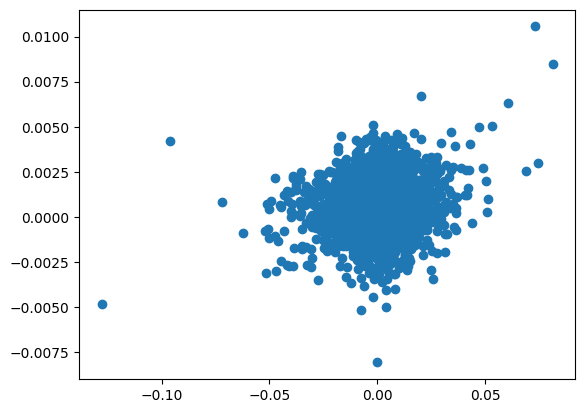

In [839]:
plt.scatter(y_train['nasdaq close change target'], ridge_y_preds)

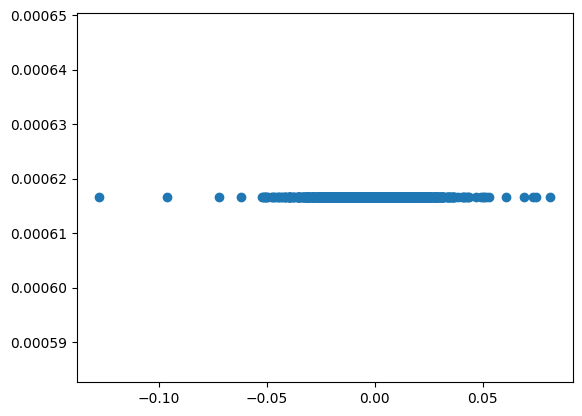

In [842]:
plt.scatter(y_train['nasdaq close change target'], lasso_y_preds)

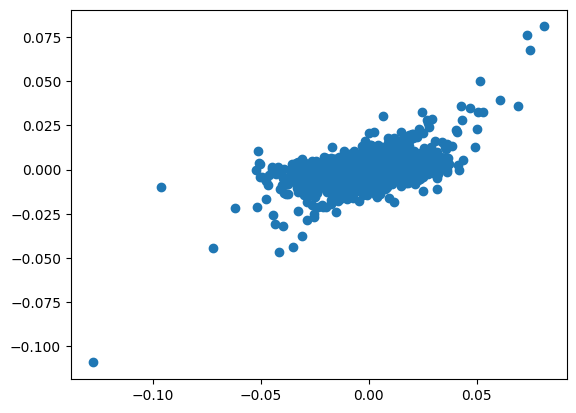

In [843]:
plt.scatter(y_train['nasdaq close change target'], linear_y_preds)

In [ ]:
y_test_pred = best_ridge_pipeline.train()

In [852]:
svm_ensemble = svm.SVR(kernel = 'poly', degree='2')
dtree_ensemble = DecisionTreeRegressor(max_depth=5)
#linear_ensemble.train(ridge)

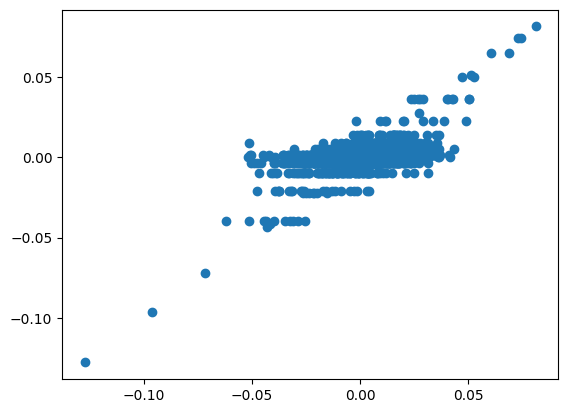

In [855]:
ensemble_input = pd.DataFrame(ridge_y_preds, columns=['ridge']).join(pd.DataFrame(linear_y_preds, columns =['linear']))
dtree_ensemble.fit(ensemble_input, y_train['nasdaq close change target'])
plt.scatter(y_train['nasdaq close change target'], dtree_ensemble.predict(ensemble_input))
#svm_ensemble.train(ensemble_input)

Now the moment of truth, can it

In [860]:
ridge_y_test_preds = best_ridge_pipeline.predict(x_test.iloc[:,1:])
linear_y_test_preds = worst_linear_pipeline.predict(x_test.iloc[:,1:])
ensemble_y_prediction = dtree_ensemble.predict(pd.DataFrame(ridge_y_test_preds, columns = ['ridge']).join(pd.DataFrame(linear_y_test_preds, columns=['linear'])))